# Anomaly Detection and Hazardous Monitoring

In [ ]:
pip install gradio

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import cv2
import glob
from tqdm import tqdm
import pandas as pd
import random

2025-06-11 10:05:42.011218: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749636342.223516      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749636342.284548      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Class For Anomaly Detection

In [4]:
class AnomalyDetection:
    def __init__(self, data_dir, img_size=(224, 224), batch_size=16):
        self.data_dir = data_dir
        self.img_size = img_size
        self.batch_size = batch_size
        self.classes = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
        self.history = None
        self.model = None
        
        # Create directories for processed data
        self.processed_data_dir = "processed_data"
        os.makedirs(self.processed_data_dir, exist_ok=True)
        os.makedirs(os.path.join(self.processed_data_dir, "train"), exist_ok=True)
        os.makedirs(os.path.join(self.processed_data_dir, "val"), exist_ok=True)
        os.makedirs(os.path.join(self.processed_data_dir, "test"), exist_ok=True)
        
    def organize_dataset(self):
        """Organize dataset by splitting into train, validation and test sets (70/15/15)"""
        print("Organizing dataset...")
        
        for class_name in tqdm(self.classes):
            class_path = os.path.join(self.data_dir, class_name)
            
            # Create class directories in processed data
            train_class_dir = os.path.join(self.processed_data_dir, "train", class_name)
            val_class_dir = os.path.join(self.processed_data_dir, "val", class_name)
            test_class_dir = os.path.join(self.processed_data_dir, "test", class_name)
            
            # Create directories for normal and anomaly
            for split in ["train", "val", "test"]:
                for label in ["good", "anomaly"]:
                    os.makedirs(os.path.join(self.processed_data_dir, split, class_name, label), exist_ok=True)
            
            # Collect all good images from train folder
            good_images = glob.glob(os.path.join(class_path, "train", "good", "*.png"))
            if not good_images:  # Try other extensions if PNG not found
                good_images = glob.glob(os.path.join(class_path, "train", "good", "*.jpg"))
                if not good_images:
                    good_images = glob.glob(os.path.join(class_path, "train", "good", "*.jpeg"))
            
            # Collect all anomaly images from test folder (all folders except 'good')
            anomaly_images = []
            test_subfolders = [f for f in os.listdir(os.path.join(class_path, "test")) 
                             if os.path.isdir(os.path.join(class_path, "test", f))]
            
            for folder in test_subfolders:
                anomaly_images.extend(glob.glob(os.path.join(class_path, "test", folder, "*.png")))
                anomaly_images.extend(glob.glob(os.path.join(class_path, "test", folder, "*.jpg")))
                anomaly_images.extend(glob.glob(os.path.join(class_path, "test", folder, "*.jpeg")))
            
            # Balance the dataset if necessary
            min_samples = min(len(good_images), len(anomaly_images))
            if len(good_images) > min_samples * 3:  # If imbalance is severe
                good_images = random.sample(good_images, min_samples * 3)
            if len(anomaly_images) > min_samples * 3:
                anomaly_images = random.sample(anomaly_images, min_samples * 3)
            
            # Split good images: 70% train, 15% val, 15% test
            train_good, temp_good = train_test_split(good_images, test_size=0.3, random_state=42)
            val_good, test_good = train_test_split(temp_good, test_size=0.5, random_state=42)
            
            # Split anomaly images: 70% train, 15% val, 15% test
            train_anomaly, temp_anomaly = train_test_split(anomaly_images, test_size=0.3, random_state=42)
            val_anomaly, test_anomaly = train_test_split(temp_anomaly, test_size=0.5, random_state=42)
            
            # Copy images to processed directories
            self._copy_images(train_good, os.path.join(self.processed_data_dir, "train", class_name, "good"))
            self._copy_images(val_good, os.path.join(self.processed_data_dir, "val", class_name, "good"))
            self._copy_images(test_good, os.path.join(self.processed_data_dir, "test", class_name, "good"))
            self._copy_images(train_anomaly, os.path.join(self.processed_data_dir, "train", class_name, "anomaly"))
            self._copy_images(val_anomaly, os.path.join(self.processed_data_dir, "val", class_name, "anomaly"))
            self._copy_images(test_anomaly, os.path.join(self.processed_data_dir, "test", class_name, "anomaly"))
            
            # Print stats for this class
            print(f"{class_name} dataset distribution:")
            print(f"  Training: {len(train_good)} good, {len(train_anomaly)} anomaly")
            print(f"  Validation: {len(val_good)} good, {len(val_anomaly)} anomaly")
            print(f"  Test: {len(test_good)} good, {len(test_anomaly)} anomaly")
        
        print("Dataset organization complete!")
        
    def _copy_images(self, image_paths, target_dir):
        """Copy images to target directory with preprocessing"""
        for img_path in image_paths:
            img_filename = os.path.basename(img_path)
            target_path = os.path.join(target_dir, img_filename)
            
            # Read and preprocess image
            img = cv2.imread(img_path)
            if img is not None:
                # Convert BGR to RGB
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                # Resize image
                img = cv2.resize(img, self.img_size)
                # Apply histogram equalization to improve contrast
                lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
                l, a, b = cv2.split(lab)
                clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
                cl = clahe.apply(l)
                updated_lab = cv2.merge((cl, a, b))
                img = cv2.cvtColor(updated_lab, cv2.COLOR_LAB2RGB)
                # Save the preprocessed image
                cv2.imwrite(target_path, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
    
    def build_model(self, weight_decay=1e-4):
        """Build a Custom CNN model for anomaly detection with regularization"""
        print("Building model...")
        
        # Initialize weight regularizer
        regularizer = l2(weight_decay)
        
        model = Sequential([
            # First convolutional block
            Conv2D(32, (3, 3), activation='relu', padding='same', 
                   kernel_regularizer=regularizer, 
                   input_shape=(*self.img_size, 3)),
            BatchNormalization(momentum=0.9),
            Conv2D(32, (3, 3), activation='relu', padding='same', 
                   kernel_regularizer=regularizer),
            BatchNormalization(momentum=0.9),
            MaxPooling2D(2, 2),
            Dropout(0.3), 
            
            # Second convolutional block
            Conv2D(64, (3, 3), activation='relu', padding='same', 
                   kernel_regularizer=regularizer),
            BatchNormalization(momentum=0.9),
            Conv2D(64, (3, 3), activation='relu', padding='same', 
                   kernel_regularizer=regularizer),
            BatchNormalization(momentum=0.9),
            MaxPooling2D(2, 2),
            Dropout(0.3),  
            
            # Third convolutional block
            Conv2D(128, (3, 3), activation='relu', padding='same', 
                   kernel_regularizer=regularizer),
            BatchNormalization(momentum=0.9),
            Conv2D(128, (3, 3), activation='relu', padding='same', 
                   kernel_regularizer=regularizer),
            BatchNormalization(momentum=0.9),
            MaxPooling2D(2, 2),
            Dropout(0.4),  
            
            # Fully connected layers
            Flatten(),
            Dense(256, activation='relu', kernel_regularizer=regularizer), 
            BatchNormalization(momentum=0.9),
            Dropout(0.5),
            Dense(len(self.classes), activation='softmax')
        ])
        
        # Compile model with a smaller learning rate
        model.compile(
            optimizer=Adam(learning_rate=0.0005), 
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        
        self.model = model
        model.summary()
        return model
    
    def train_model(self, epochs=50):  # Increased max epochs
        """Train the model using data generators and advanced callbacks"""
        print("Training model...")
        
        # Moderate data augmentation for training
        train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=15,  
            width_shift_range=0.1,  
            height_shift_range=0.1, 
            shear_range=0.1,  
            zoom_range=0.1,  
            horizontal_flip=True,
            fill_mode='nearest',
            brightness_range=[0.9, 1.1]  
        )
        
        # Mild augmentation for validation - helps model generalize better
        val_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=5,
            width_shift_range=0.05,
            height_shift_range=0.05
        )
        
        # Test data only needs rescaling
        test_datagen = ImageDataGenerator(rescale=1./255)
        
        # Flow from directory with class mode
        train_generator = train_datagen.flow_from_directory(
            os.path.join(self.processed_data_dir, "train"),
            target_size=self.img_size,
            batch_size=self.batch_size,
            class_mode='categorical',
            shuffle=True
        )
        
        validation_generator = val_datagen.flow_from_directory(
            os.path.join(self.processed_data_dir, "val"),
            target_size=self.img_size,
            batch_size=self.batch_size,
            class_mode='categorical',
            shuffle=True
        )
        
        test_generator = test_datagen.flow_from_directory(
            os.path.join(self.processed_data_dir, "test"),
            target_size=self.img_size,
            batch_size=self.batch_size,
            class_mode='categorical',
            shuffle=False
        )
        
        # Define advanced callbacks
        checkpoint = ModelCheckpoint(
            'best_model.h5', 
            monitor='val_accuracy', 
            verbose=1, 
            save_best_only=True, 
            mode='max'
        )
        
        # More patient early stopping
        early_stopping = EarlyStopping(
            monitor='val_accuracy',
            patience=10,  # Increased from 5
            verbose=1,
            restore_best_weights=True
        )
        
        # Learning rate reduction when plateauing
        reduce_lr = ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            min_lr=0.00001,
            verbose=1
        )
        
        # Calculate steps per epoch to ensure we see all data
        steps_per_epoch = max(train_generator.samples // self.batch_size, 1)
        validation_steps = max(validation_generator.samples // self.batch_size, 1)
        
        # Train the model
        self.history = self.model.fit(
            train_generator,
            steps_per_epoch=steps_per_epoch,
            epochs=epochs,
            validation_data=validation_generator,
            validation_steps=validation_steps,
            callbacks=[checkpoint, early_stopping, reduce_lr],
            verbose=1
        )
        
        # Load best model weights
        self.model.load_weights('best_model.h5')
        print("Training complete!")
        
        return self.history
    
    def evaluate_model(self):
        """Evaluate model and generate performance metrics"""
        print("Evaluating model...")
        
        # Data generator for test data
        test_datagen = ImageDataGenerator(rescale=1./255)
        test_generator = test_datagen.flow_from_directory(
            os.path.join(self.processed_data_dir, "test"),
            target_size=self.img_size,
            batch_size=1,  # Batch size of 1 to get predictions for individual images
            class_mode='categorical',
            shuffle=False
        )
        
        # Get true labels
        true_labels = test_generator.classes
        
        # Get class indices to label mapping
        class_indices = test_generator.class_indices
        class_names = list(class_indices.keys())
        
        # Get predictions
        predictions = self.model.predict(test_generator, steps=test_generator.samples)
        predicted_classes = np.argmax(predictions, axis=1)
        
        # Calculate metrics
        accuracy = accuracy_score(true_labels, predicted_classes)
        precision = precision_score(true_labels, predicted_classes, average='weighted')
        recall = recall_score(true_labels, predicted_classes, average='weighted')
        f1 = f1_score(true_labels, predicted_classes, average='weighted')
        
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")
        
        # Generate classification report
        print("\nClassification Report:")
        print(classification_report(true_labels, predicted_classes, target_names=class_names))
        
        # Create confusion matrix
        cm = confusion_matrix(true_labels, predicted_classes)
        
        # Normalize confusion matrix
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'confusion_matrix': cm,
            'normalized_confusion_matrix': cm_normalized,
            'class_names': class_names,
            'true_labels': true_labels,
            'predicted_classes': predicted_classes
        }
    
    def plot_training_history(self):
        """Plot accuracy and loss curves with enhanced visualization"""
        plt.figure(figsize=(16, 6))
        
        # Plot accuracy with smoothing
        plt.subplot(1, 2, 1)
        # Apply simple moving average to smooth the validation curves
        window_size = 3
        val_acc_smooth = np.convolve(self.history.history['val_accuracy'], 
                                     np.ones(window_size)/window_size, mode='valid')
        
        epochs_range = range(len(self.history.history['accuracy']))
        smooth_range = range(len(val_acc_smooth))
        
        plt.plot(epochs_range, self.history.history['accuracy'], 'b-', 
                 linewidth=2, label='Training Accuracy')
        plt.plot(smooth_range, val_acc_smooth, 'r-', 
                 linewidth=2, label='Smoothed Validation Accuracy')
        plt.plot(epochs_range, self.history.history['val_accuracy'], 'r--', 
                 alpha=0.5, label='Raw Validation Accuracy')
        
        plt.title('Model Accuracy', fontsize=14)
        plt.ylabel('Accuracy', fontsize=12)
        plt.xlabel('Epoch', fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend(fontsize=10)
        plt.ylim([0, 1.05])
        
        # Plot loss with smoothing
        plt.subplot(1, 2, 2)
        # Apply simple moving average to smooth the validation curves
        val_loss_smooth = np.convolve(self.history.history['val_loss'], 
                                      np.ones(window_size)/window_size, mode='valid')
        
        plt.plot(epochs_range, self.history.history['loss'], 'b-', 
                 linewidth=2, label='Training Loss')
        plt.plot(smooth_range, val_loss_smooth, 'r-', 
                 linewidth=2, label='Smoothed Validation Loss')
        plt.plot(epochs_range, self.history.history['val_loss'], 'r--', 
                 alpha=0.5, label='Raw Validation Loss')
        
        plt.title('Model Loss', fontsize=14)
        plt.ylabel('Loss', fontsize=12)
        plt.xlabel('Epoch', fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend(fontsize=10)
        
        plt.tight_layout()
        plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def plot_confusion_matrix(self, cm, class_names):
        """Plot confusion matrix as a heatmap with improved visualization"""
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', 
                   xticklabels=class_names, yticklabels=class_names)
        plt.xlabel('Predicted Label', fontsize=12)
        plt.ylabel('True Label', fontsize=12)
        plt.title('Normalized Confusion Matrix', fontsize=14)
        plt.tight_layout()
        plt.savefig('confusion_matrix.png', dpi=300)
        plt.show()
    
    def run_full_pipeline(self, epochs=20):  
        """Run the full anomaly detection pipeline with improved training process"""
        # Organize dataset with train/val/test split
        self.organize_dataset()
        
        # Build and train model
        self.build_model(weight_decay=1e-4)
        self.train_model(epochs=epochs)
        
        # Evaluate model
        eval_results = self.evaluate_model()
        
        # Plot results
        self.plot_training_history()
        self.plot_confusion_matrix(eval_results['normalized_confusion_matrix'], eval_results['class_names'])
        
        return eval_results


# Run Anomaly Detection

Organizing dataset...


  7%|▋         | 1/15 [00:25<05:56, 25.48s/it]

wood dataset distribution:
  Training: 165 good, 55 anomaly
  Validation: 36 good, 12 anomaly
  Test: 36 good, 12 anomaly


 13%|█▎        | 2/15 [00:45<04:50, 22.36s/it]

screw dataset distribution:
  Training: 224 good, 112 anomaly
  Validation: 48 good, 24 anomaly
  Test: 48 good, 24 anomaly


 20%|██        | 3/15 [01:00<03:46, 18.91s/it]

metal_nut dataset distribution:
  Training: 154 good, 80 anomaly
  Validation: 33 good, 17 anomaly
  Test: 33 good, 18 anomaly


 27%|██▋       | 4/15 [01:25<03:55, 21.40s/it]

capsule dataset distribution:
  Training: 153 good, 92 anomaly
  Validation: 33 good, 20 anomaly
  Test: 33 good, 20 anomaly


 33%|███▎      | 5/15 [01:57<04:12, 25.28s/it]

hazelnut dataset distribution:
  Training: 231 good, 77 anomaly
  Validation: 49 good, 16 anomaly
  Test: 50 good, 17 anomaly


 40%|████      | 6/15 [02:30<04:11, 27.93s/it]

carpet dataset distribution:
  Training: 196 good, 81 anomaly
  Validation: 42 good, 18 anomaly
  Test: 42 good, 18 anomaly


 47%|████▋     | 7/15 [02:53<03:29, 26.14s/it]

pill dataset distribution:
  Training: 186 good, 116 anomaly
  Validation: 40 good, 25 anomaly
  Test: 41 good, 26 anomaly


 53%|█████▎    | 8/15 [03:06<02:33, 21.89s/it]

grid dataset distribution:
  Training: 163 good, 54 anomaly
  Validation: 35 good, 12 anomaly
  Test: 36 good, 12 anomaly


 60%|██████    | 9/15 [03:20<01:58, 19.67s/it]

zipper dataset distribution:
  Training: 168 good, 105 anomaly
  Validation: 36 good, 23 anomaly
  Test: 36 good, 23 anomaly


 67%|██████▋   | 10/15 [03:44<01:44, 20.89s/it]

transistor dataset distribution:
  Training: 149 good, 70 anomaly
  Validation: 32 good, 15 anomaly
  Test: 32 good, 15 anomaly


 73%|███████▎  | 11/15 [04:05<01:23, 20.91s/it]

tile dataset distribution:
  Training: 161 good, 81 anomaly
  Validation: 34 good, 18 anomaly
  Test: 35 good, 18 anomaly


 80%|████████  | 12/15 [04:31<01:07, 22.49s/it]

leather dataset distribution:
  Training: 171 good, 86 anomaly
  Validation: 37 good, 19 anomaly
  Test: 37 good, 19 anomaly


 87%|████████▋ | 13/15 [04:38<00:35, 17.87s/it]

toothbrush dataset distribution:
  Training: 42 good, 29 anomaly
  Validation: 9 good, 6 anomaly
  Test: 9 good, 7 anomaly


 93%|█████████▎| 14/15 [04:53<00:16, 16.86s/it]

bottle dataset distribution:
  Training: 146 good, 58 anomaly
  Validation: 31 good, 12 anomaly
  Test: 32 good, 13 anomaly


100%|██████████| 15/15 [05:21<00:00, 21.46s/it]

cable dataset distribution:
  Training: 156 good, 105 anomaly
  Validation: 34 good, 22 anomaly
  Test: 34 good, 23 anomaly
Dataset organization complete!
Building model...



/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1749570789.959036      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1749570789.959889      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 224, 224, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 112, 112, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 56, 56, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 25,984,047 (99.12 MB)

 Trainable params: 25,982,639 (99.12 MB)

 Non-trainable params: 1,408 (5.50 KB)

Training model...
Found 2883 images belonging to 15 classes.
Found 727 images belonging to 15 classes.
Found 726 images belonging to 15 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30


I0000 00:00:1749570803.057413     114 service.cc:148] XLA service 0x7d26c0002630 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749570803.059079     114 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1749570803.059108     114 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1749570804.113620     114 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/120 ━━━━━━━━━━━━━━━━━━━━ 54:35 28s/step - accuracy: 0.0000e+00 - loss: 4.7825

I0000 00:00:1749570820.699643     114 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step - accuracy: 0.8032 - loss: 0.8405
Epoch 1: val_accuracy improved from -inf to 0.69861, saving model to best_model.h5
120/120 ━━━━━━━━━━━━━━━━━━━━ 97s 583ms/step - accuracy: 0.8042 - loss: 0.8367 - val_accuracy: 0.6986 - val_loss: 11.9238 - learning_rate: 5.0000e-04
Epoch 2/30
  1/120 ━━━━━━━━━━━━━━━━━━━━ 18s 159ms/step - accuracy: 1.0000 - loss: 0.1536

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy did not improve from 0.69861
120/120 ━━━━━━━━━━━━━━━━━━━━ 9s 78ms/step - accuracy: 1.0000 - loss: 0.1536 - val_accuracy: 0.6958 - val_loss: 12.1907 - learning_rate: 5.0000e-04
Epoch 3/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.9950 - loss: 0.1353
Epoch 3: val_accuracy improved from 0.69861 to 0.79028, saving model to best_model.h5
120/120 ━━━━━━━━━━━━━━━━━━━━ 57s 472ms/step - accuracy: 0.9950 - loss: 0.1354 - val_accuracy: 0.7903 - val_loss: 6.1796 - learning_rate: 5.0000e-04
Epoch 4/30
  1/120 ━━━━━━━━━━━━━━━━━━━━ 18s 157ms/step - accuracy: 0.9583 - loss: 0.2063
Epoch 4: val_accuracy did not improve from 0.79028
120/120 ━━━━━━━━━━━━━━━━━━━━ 9s 78ms/step - accuracy: 0.9583 - loss: 0.2063 - val_accuracy: 0.7861 - val_loss: 6.5540 - learning_rate: 5.0000e-04
Epoch 5/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.9912 - loss: 0.1542
Epoch 5: val_accuracy improved from 0.79028 to 0.90833, saving model to best_model.h5
120/120 ━━━━━━━━━━━

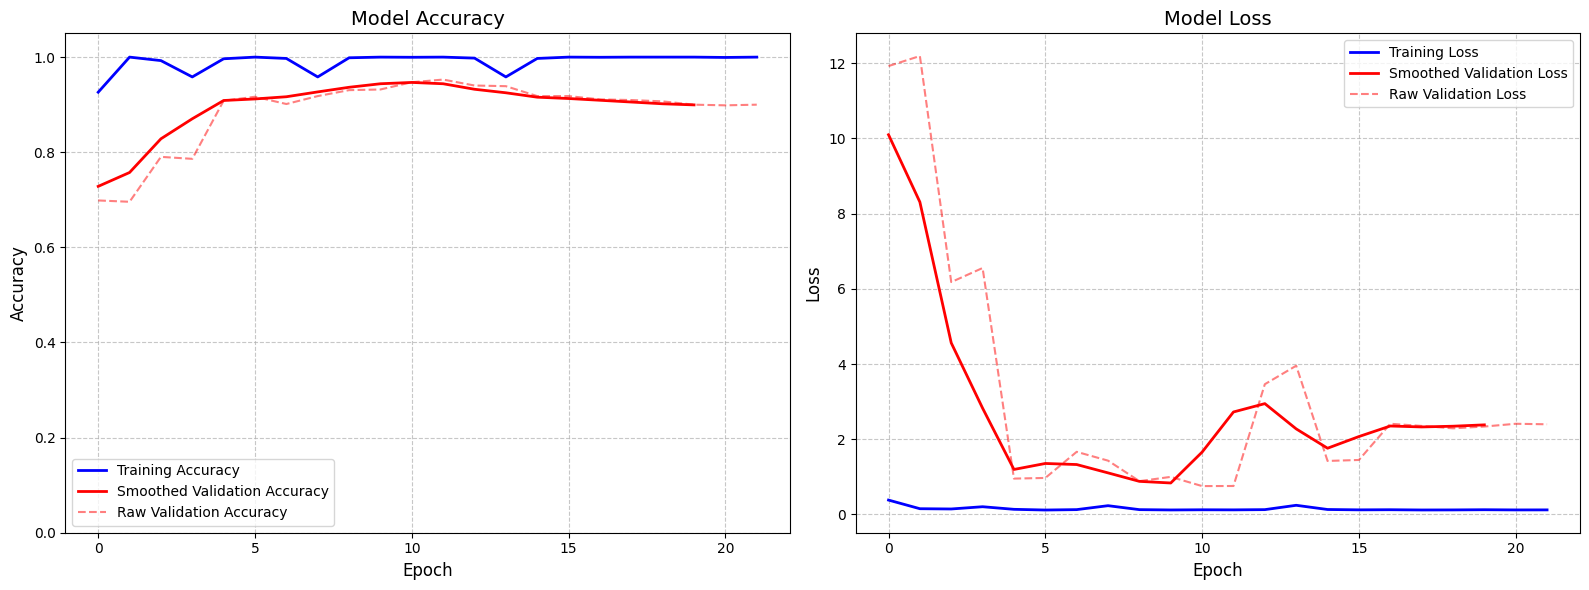

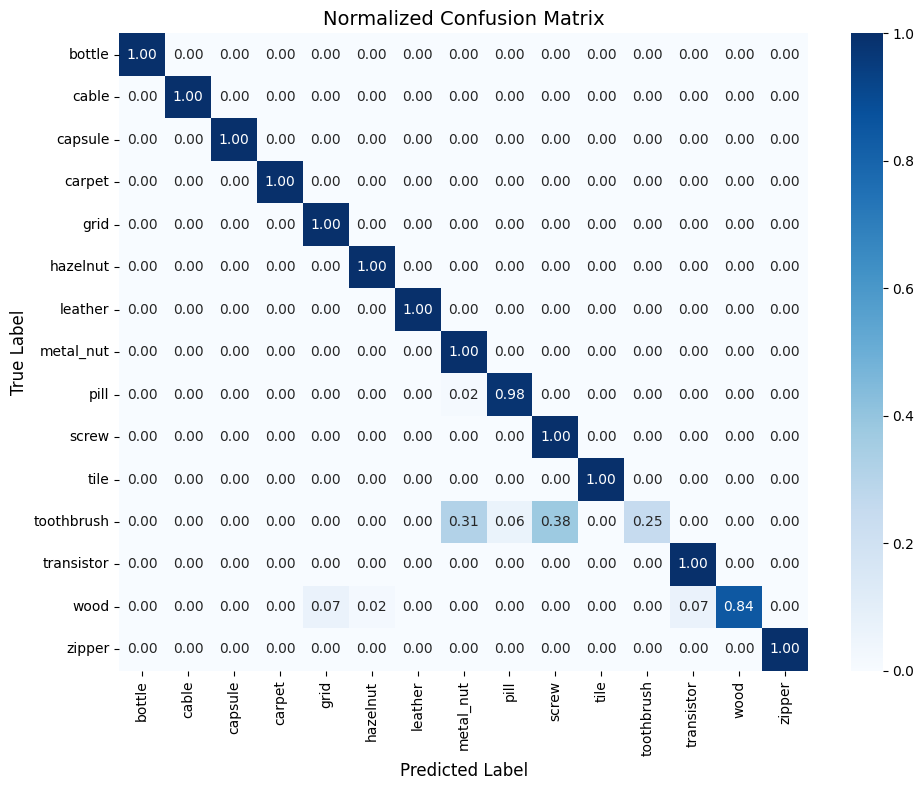


Overall Performance Metrics:
Accuracy: 0.9725
Precision: 0.9747
Recall: 0.9725
F1 Score: 0.9677


In [5]:
# Main execution
if __name__ == "__main__":
    # Set up the data directory
    DATA_DIR = "/kaggle/input/anomaly-dataset/mvtec_anomaly_detection"
    
    # Initialize and run anomaly detection
    detector = AnomalyDetection(
        data_dir=DATA_DIR, 
        img_size=(224, 224),
        batch_size=24  # Reduced from 32
    )
    
    results = detector.run_full_pipeline(epochs=30)  # Increased from 30
    
    # Display overall metrics
    print("\nOverall Performance Metrics:")
    print(f"Accuracy: {results['accuracy']:.4f}")
    print(f"Precision: {results['precision']:.4f}")
    print(f"Recall: {results['recall']:.4f}")
    print(f"F1 Score: {results['f1']:.4f}")

# Code For Hazardous Monitoring

In [1]:
pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 19.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 29.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 65.2 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found exi

In [2]:
import os
import glob
import shutil
import random
import yaml
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
# 1. Configuration
SOURCE_DIR   = '/kaggle/input/d/eliasschramm/hazmat13/trained-dataset.zip/trained-dataset'  # read-only source
BASE_DIR     = '/kaggle/working/hazmat_dataset'  # writable working directory
IMGS_DIR     = os.path.join(SOURCE_DIR, 'images')
LABS_DIR     = os.path.join(SOURCE_DIR, 'labels')
NAMES_FILE   = os.path.join(SOURCE_DIR, 'hazmat.names')
DATA_YAML    = os.path.join(BASE_DIR, 'data.yaml')
OUTPUT_DIR   = 'runs'                  # where YOLOv8 writes its runs
EPOCHS       = 20
IMG_SIZE     = 224
MODEL_PT     = 'yolov8m.pt'            # medium YOLOv8 checkpoint

TRAIN_SPLIT  = 0.8                     # 80% train, 20% val
SEED         = 42

In [4]:
# 2. Create working directory structure
os.makedirs(BASE_DIR, exist_ok=True)
for split in ['train', 'val']:
    for sub in ['images', 'labels']:
        os.makedirs(os.path.join(BASE_DIR, sub, split), exist_ok=True)


In [5]:
# 3. Load class names
with open(NAMES_FILE, 'r') as f:
    names = [l.strip() for l in f if l.strip()]
nc = len(names)

In [6]:
# 4. Gather all image files
all_imgs = [f for f in os.listdir(IMGS_DIR)
            if f.lower().endswith(('.jpg','.jpeg','.png'))]
train_imgs, val_imgs = train_test_split(all_imgs, train_size=TRAIN_SPLIT, random_state=SEED)

print(f"Total images: {len(all_imgs)}")
print(f"Train images: {len(train_imgs)}")
print(f"Val images: {len(val_imgs)}")

Total images: 52885
Train images: 42308
Val images: 10577


In [7]:
# 5. Copy files to train/val folders
for split, files in [('train', train_imgs), ('val', val_imgs)]:
    print(f"Copying {split} files...")
    for img in files:
        # copy image
        src_img = os.path.join(IMGS_DIR, img)
        dst_img = os.path.join(BASE_DIR, 'images', split, img)
        shutil.copy(src_img, dst_img)
        
        # copy corresponding .txt label
        lbl = os.path.splitext(img)[0] + '.txt'
        src_lbl = os.path.join(LABS_DIR, lbl)
        dst_lbl = os.path.join(BASE_DIR, 'labels', split, lbl)
        
        # Check if label file exists before copying
        if os.path.exists(src_lbl):
            shutil.copy(src_lbl, dst_lbl)
        else:
            print(f"Warning: Label file not found for {img}")

Copying train files...
Copying val files...


In [8]:
# 6. Write data.yaml for YOLOv8
data_cfg = {
    'path': BASE_DIR,  # dataset root dir
    'train': 'images/train',  # relative to 'path'
    'val': 'images/val',      # relative to 'path'
    'nc': nc,
    'names': names
}
with open(DATA_YAML, 'w') as fp:
    yaml.dump(data_cfg, fp, sort_keys=False)

print(f"Created data.yaml with {nc} classes:")
for i, name in enumerate(names):
    print(f"  {i}: {name}")

Created data.yaml with 13 classes:
  0: poison
  1: oxygen
  2: flammable
  3: flammable-solid
  4: corrosive
  5: dangerous
  6: non-flammable-gas
  7: organic-peroxide
  8: explosive
  9: radioactive
  10: inhalation-hazard
  11: spontaneously-combustible
  12: infectious-substance


In [9]:
# 7. Train YOLOv8 model
print("Starting training...")
model = YOLO(MODEL_PT)
results = model.train(data=DATA_YAML,
                      epochs=EPOCHS,
                      imgsz=IMG_SIZE,
                      project='runs',
                      name='hazmat_detection')

Starting training...


100%|██████████| 49.7M/49.7M [00:00<00:00, 262MB/s]


Ultralytics 8.3.153 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/hazmat_dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=224, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=hazmat_detection, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True

100%|██████████| 755k/755k [00:00<00:00, 17.5MB/s]


Overriding model.yaml nc=80 with nc=13

                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1   1991808  ultralytic

100%|██████████| 5.35M/5.35M [00:00<00:00, 70.4MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 781.9±783.4 MB/s, size: 57.0 KB)


train: Scanning /kaggle/working/hazmat_dataset/labels/train... 42308 images, 0 backgrounds, 0 corrupt: 100%|██████████| 42308/42308 [00:33<00:00, 1244.70it/s]


train: New cache created: /kaggle/working/hazmat_dataset/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 668.9±168.7 MB/s, size: 68.7 KB)


val: Scanning /kaggle/working/hazmat_dataset/labels/val... 10576 images, 0 backgrounds, 1 corrupt: 100%|██████████| 10577/10577 [00:08<00:00, 1230.37it/s]

val: /kaggle/working/hazmat_dataset/images/val/image24953.jpg: ignoring corrupt image/label: image file is truncated (6599 bytes not processed)


val: New cache created: /kaggle/working/hazmat_dataset/labels/val.cache
Plotting labels to runs/hazmat_detection/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 224 train, 224 val
Using 2 dataloader workers
Logging results to runs/hazmat_detection
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      1.18G     0.7811      0.945     0.9453         14        224: 100%|██████████| 2645/2645 [05:25<00:00,  8.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 331/331 [00:50<00:00,  6.57it/s]


                   all      10576      17907      0.948      0.943      0.965      0.801

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20       1.5G     0.7716     0.5608     0.9192          7        224: 100%|██████████| 2645/2645 [05:12<00:00,  8.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 331/331 [00:50<00:00,  6.57it/s]


                   all      10576      17907       0.96      0.941      0.977      0.807

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      1.54G     0.8042     0.5928      0.931         13        224: 100%|██████████| 2645/2645 [05:00<00:00,  8.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 331/331 [00:49<00:00,  6.70it/s]


                   all      10576      17907      0.959      0.947      0.977      0.803

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      1.59G     0.8017      0.579     0.9331          9        224: 100%|██████████| 2645/2645 [05:00<00:00,  8.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 331/331 [00:49<00:00,  6.62it/s]


                   all      10576      17907      0.968       0.96      0.982      0.819

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      1.63G     0.7559     0.5116     0.9207         13        224: 100%|██████████| 2645/2645 [04:58<00:00,  8.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 331/331 [00:48<00:00,  6.85it/s]

                   all      10576      17907      0.975      0.966      0.985      0.833



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20       1.7G     0.7305      0.475     0.9143         13        224: 100%|██████████| 2645/2645 [05:02<00:00,  8.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 331/331 [00:49<00:00,  6.68it/s]

                   all      10576      17907      0.975      0.973      0.987       0.84



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      1.82G     0.7094     0.4485     0.9103         15        224: 100%|██████████| 2645/2645 [04:59<00:00,  8.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 331/331 [00:49<00:00,  6.72it/s]

                   all      10576      17907      0.976      0.977      0.988      0.848



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      1.99G     0.6935     0.4238      0.904          9        224: 100%|██████████| 2645/2645 [05:07<00:00,  8.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 331/331 [00:50<00:00,  6.52it/s]

                   all      10576      17907      0.982      0.976      0.989      0.855



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      2.03G     0.6793     0.4129     0.9012         14        224: 100%|██████████| 2645/2645 [05:07<00:00,  8.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 331/331 [00:51<00:00,  6.44it/s]

                   all      10576      17907      0.983      0.978      0.991      0.859



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20       2.1G     0.6643     0.3921     0.8957          9        224: 100%|██████████| 2645/2645 [05:00<00:00,  8.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 331/331 [00:51<00:00,  6.48it/s]


                   all      10576      17907      0.983      0.981      0.991      0.864
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      2.22G     0.6297      0.342     0.8716          9        224: 100%|██████████| 2645/2645 [05:01<00:00,  8.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 331/331 [00:52<00:00,  6.25it/s]

                   all      10576      17907       0.98      0.984      0.991      0.865



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      2.39G     0.6158     0.3293     0.8654          7        224: 100%|██████████| 2645/2645 [05:11<00:00,  8.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 331/331 [00:52<00:00,  6.26it/s]

                   all      10576      17907      0.986      0.979      0.992       0.87



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      2.43G     0.6015     0.3146      0.861          5        224: 100%|██████████| 2645/2645 [05:11<00:00,  8.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 331/331 [00:52<00:00,  6.28it/s]

                   all      10576      17907      0.981      0.986      0.991      0.874



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      2.51G     0.5873     0.3018     0.8588          9        224: 100%|██████████| 2645/2645 [05:11<00:00,  8.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 331/331 [00:53<00:00,  6.24it/s]

                   all      10576      17907       0.98      0.985      0.992      0.878



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      2.62G     0.5722     0.2893     0.8546          7        224: 100%|██████████| 2645/2645 [05:14<00:00,  8.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 331/331 [00:53<00:00,  6.20it/s]

                   all      10576      17907      0.982      0.984      0.992      0.881



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      2.78G     0.5604     0.2784     0.8523          5        224: 100%|██████████| 2645/2645 [05:09<00:00,  8.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 331/331 [00:51<00:00,  6.42it/s]

                   all      10576      17907      0.982      0.985      0.992      0.884



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      2.83G     0.5466     0.2692     0.8485          5        224: 100%|██████████| 2645/2645 [05:07<00:00,  8.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 331/331 [00:52<00:00,  6.30it/s]


                   all      10576      17907      0.985      0.982      0.992      0.886

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      2.92G     0.5333     0.2591     0.8451          7        224: 100%|██████████| 2645/2645 [05:10<00:00,  8.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 331/331 [00:52<00:00,  6.28it/s]

                   all      10576      17907      0.985      0.983      0.992      0.889



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      3.04G     0.5175     0.2473     0.8398          6        224: 100%|██████████| 2645/2645 [05:08<00:00,  8.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 331/331 [00:53<00:00,  6.24it/s]

                   all      10576      17907      0.986      0.983      0.992       0.89



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20       3.2G     0.5049      0.237     0.8393          6        224: 100%|██████████| 2645/2645 [05:12<00:00,  8.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 331/331 [00:52<00:00,  6.29it/s]

                   all      10576      17907      0.987      0.983      0.992      0.891



20 epochs completed in 2.001 hours.
Optimizer stripped from runs/hazmat_detection/weights/last.pt, 52.0MB
Optimizer stripped from runs/hazmat_detection/weights/best.pt, 52.0MB

Validating runs/hazmat_detection/weights/best.pt...
Ultralytics 8.3.153 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 92 layers, 25,847,287 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 331/331 [00:57<00:00,  5.80it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all      10576      17907      0.987      0.983      0.992       0.89
                poison        768        768      0.999          1      0.995      0.913
                oxygen        995       1402      0.987      0.995      0.995      0.902
             flammable        958       1510      0.991      0.987      0.994      0.869
       flammable-solid        949       1456      0.985      0.979      0.993      0.876
             corrosive       1016       1355      0.991      0.992      0.993      0.886
             dangerous        896       1340      0.996      0.984      0.995      0.886
     non-flammable-gas        942       1262      0.993      0.998      0.994      0.919
      organic-peroxide        914       1222      0.995      0.991      0.994      0.902
             explosive       1043       1870      0.972      0.961       0.99      0.865
           radioactive        919       1561      0.983      0.947      0.983      0.866
     inhalation-hazar

In [10]:
# 8. Load the metrics CSV from the latest run
metrics_files = glob.glob(os.path.join(OUTPUT_DIR, 'hazmat_detection*', 'results.csv'))
if not metrics_files:
    # Try alternative path structure
    metrics_files = glob.glob(os.path.join('runs', 'detect', 'hazmat_detection*', 'results.csv'))
if not metrics_files:
    raise FileNotFoundError("Could not find results.csv under runs/")

metrics_file = max(metrics_files, key=os.path.getctime)  # get most recent
print(f"Loading metrics from: {metrics_file}")
df = pd.read_csv(metrics_file)

Loading metrics from: runs/hazmat_detection/results.csv


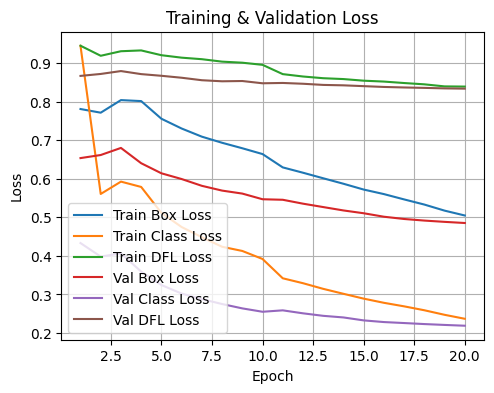

In [11]:
# 9. Plot loss curves
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(df['epoch'], df['train/box_loss'], label='Train Box Loss')
plt.plot(df['epoch'], df['train/cls_loss'], label='Train Class Loss')
plt.plot(df['epoch'], df['train/dfl_loss'], label='Train DFL Loss')
plt.plot(df['epoch'], df['val/box_loss'], label='Val Box Loss')
plt.plot(df['epoch'], df['val/cls_loss'], label='Val Class Loss')
plt.plot(df['epoch'], df['val/dfl_loss'], label='Val DFL Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.grid(True)

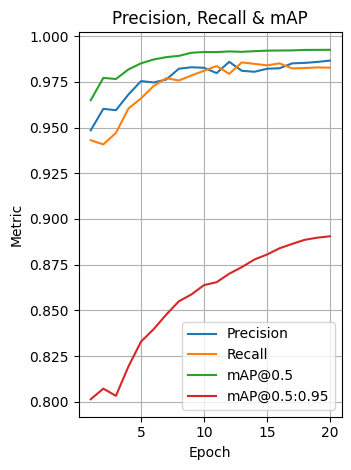

In [12]:
# 10. Plot Precision, Recall, mAP
plt.subplot(1, 2, 2)
plt.plot(df['epoch'], df['metrics/precision(B)'], label='Precision')
plt.plot(df['epoch'], df['metrics/recall(B)'], label='Recall')
plt.plot(df['epoch'], df['metrics/mAP50(B)'], label='mAP@0.5')
plt.plot(df['epoch'], df['metrics/mAP50-95(B)'], label='mAP@0.5:0.95')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.title('Precision, Recall & mAP')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('training_metrics.png', dpi=150, bbox_inches='tight')
plt.show()

In [13]:
# 11. Final evaluation
print("Running final validation...")
val_results = model.val(data=DATA_YAML,
                        imgsz=IMG_SIZE,
                        conf=0.25)

print("\n✅ Training complete.")
print("  • training_metrics.png")
print(f"  • Model saved in: runs/detect/hazmat_detection*/weights/")
print(f"  • Best weights: runs/detect/hazmat_detection*/weights/best.pt")

Running final validation...
Ultralytics 8.3.153 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 92 layers, 25,847,287 parameters, 0 gradients, 78.7 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1362.7±673.5 MB/s, size: 113.8 KB)


val: Scanning /kaggle/working/hazmat_dataset/labels/val.cache... 10576 images, 0 backgrounds, 1 corrupt: 100%|██████████| 10577/10577 [00:00<?, ?it/s]

val: /kaggle/working/hazmat_dataset/images/val/image24953.jpg: ignoring corrupt image/label: image file is truncated (6599 bytes not processed)



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 661/661 [01:04<00:00, 10.32it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all      10576      17907      0.987      0.983      0.992      0.901
                poison        768        768      0.999          1      0.995      0.919
                oxygen        995       1402      0.987      0.995      0.995       0.91
             flammable        958       1510      0.991      0.987      0.994      0.884
       flammable-solid        949       1456      0.985      0.979      0.991      0.893
             corrosive       1016       1355      0.991      0.992      0.993      0.894
             dangerous        896       1340      0.996      0.984      0.995      0.895
     non-flammable-gas        942       1262      0.993      0.998      0.994      0.924
      organic-peroxide        914       1222      0.995      0.991      0.994      0.911
             explosive       1043       1870      0.972      0.961       0.99      0.879
           radioactive        919       1561      0.983      0.946      0.983      0.882
     inhalation-hazar

In [14]:
import pandas as pd
import glob
import os

# Load the metrics CSV from the latest run
metrics_files = glob.glob(os.path.join('runs', 'detect', 'hazmat_detection*', 'results.csv'))
if not metrics_files:
    metrics_files = glob.glob(os.path.join('runs', 'hazmat_detection*', 'results.csv'))

metrics_file = max(metrics_files, key=os.path.getctime)  # get most recent
df = pd.read_csv(metrics_file)

print("=" * 80)
print("TRAINING METRICS SUMMARY")
print("=" * 80)

# Per-epoch metrics
print("\n📊 PER-EPOCH METRICS:")
print("-" * 60)
print(f"{'Epoch':<6} {'Precision':<10} {'Recall':<10} {'mAP@0.5':<10} {'mAP@0.5:0.95':<12}")
print("-" * 60)

for _, row in df.iterrows():
    epoch = int(row['epoch'])
    precision = row['metrics/precision(B)']
    recall = row['metrics/recall(B)']
    map50 = row['metrics/mAP50(B)']
    map50_95 = row['metrics/mAP50-95(B)']
    
    print(f"{epoch:<6} {precision:<10.4f} {recall:<10.4f} {map50:<10.4f} {map50_95:<12.4f}")

# Overall best metrics
print("\n" + "=" * 60)
print("🏆 BEST OVERALL METRICS:")
print("=" * 60)

best_precision = df['metrics/precision(B)'].max()
best_recall = df['metrics/recall(B)'].max()
best_map50 = df['metrics/mAP50(B)'].max()
best_map50_95 = df['metrics/mAP50-95(B)'].max()

# Find epochs where best values occurred
best_precision_epoch = df.loc[df['metrics/precision(B)'].idxmax(), 'epoch']
best_recall_epoch = df.loc[df['metrics/recall(B)'].idxmax(), 'epoch']
best_map50_epoch = df.loc[df['metrics/mAP50(B)'].idxmax(), 'epoch']
best_map50_95_epoch = df.loc[df['metrics/mAP50-95(B)'].idxmax(), 'epoch']

print(f"Best Precision:     {best_precision:.4f} (Epoch {int(best_precision_epoch)})")
print(f"Best Recall:        {best_recall:.4f} (Epoch {int(best_recall_epoch)})")
print(f"Best mAP@0.5:       {best_map50:.4f} (Epoch {int(best_map50_epoch)})")
print(f"Best mAP@0.5:0.95:  {best_map50_95:.4f} (Epoch {int(best_map50_95_epoch)})")

# Final epoch metrics
final_epoch = df.iloc[-1]
print("\n" + "=" * 60)
print("📈 FINAL EPOCH METRICS:")
print("=" * 60)
print(f"Final Precision:    {final_epoch['metrics/precision(B)']:.4f}")
print(f"Final Recall:       {final_epoch['metrics/recall(B)']:.4f}")
print(f"Final mAP@0.5:      {final_epoch['metrics/mAP50(B)']:.4f}")
print(f"Final mAP@0.5:0.95: {final_epoch['metrics/mAP50-95(B)']:.4f}")

# Calculate F1 Score (harmonic mean of precision and recall)
print("\n" + "=" * 60)
print("🎯 F1 SCORES:")
print("=" * 60)

# Per-epoch F1 scores
df['f1_score'] = 2 * (df['metrics/precision(B)'] * df['metrics/recall(B)']) / (df['metrics/precision(B)'] + df['metrics/recall(B)'])

print("Per-epoch F1 Scores:")
print("-" * 30)
for _, row in df.iterrows():
    epoch = int(row['epoch'])
    f1 = row['f1_score']
    print(f"Epoch {epoch:<3}: {f1:.4f}")

best_f1 = df['f1_score'].max()
best_f1_epoch = df.loc[df['f1_score'].idxmax(), 'epoch']
final_f1 = df.iloc[-1]['f1_score']

print(f"\nBest F1 Score:      {best_f1:.4f} (Epoch {int(best_f1_epoch)})")
print(f"Final F1 Score:     {final_f1:.4f}")

print("\n" + "=" * 80)
print("✅ METRICS SUMMARY COMPLETE")
print("=" * 80)

TRAINING METRICS SUMMARY

📊 PER-EPOCH METRICS:
------------------------------------------------------------
Epoch  Precision  Recall     mAP@0.5    mAP@0.5:0.95
------------------------------------------------------------
1      0.9485     0.9430     0.9649     0.8014      
2      0.9602     0.9408     0.9771     0.8072      
3      0.9595     0.9470     0.9765     0.8033      
4      0.9681     0.9604     0.9818     0.8194      
5      0.9754     0.9659     0.9851     0.8330      
6      0.9746     0.9728     0.9872     0.8398      
7      0.9762     0.9770     0.9885     0.8477      
8      0.9821     0.9757     0.9892     0.8550      
9      0.9829     0.9785     0.9909     0.8587      
10     0.9827     0.9810     0.9913     0.8638      
11     0.9797     0.9836     0.9912     0.8654      
12     0.9859     0.9794     0.9916     0.8700      
13     0.9810     0.9856     0.9914     0.8737      
14     0.9805     0.9848     0.9918     0.8778      
15     0.9821     0.9840     0.9920 

# Code for Predictive Maintanence

In [3]:
df=pd.read_csv("/kaggle/input/predictive-maintenance-dataset-ai4i-2020/ai4i2020.csv")

In [4]:
df

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,M24855,M,298.8,308.4,1604,29.5,14,0,0,0,0,0,0
9996,9997,H39410,H,298.9,308.4,1632,31.8,17,0,0,0,0,0,0
9997,9998,M24857,M,299.0,308.6,1645,33.4,22,0,0,0,0,0,0
9998,9999,H39412,H,299.0,308.7,1408,48.5,25,0,0,0,0,0,0


In [5]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

In [6]:
df[df["Machine failure"]==1]

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
50,51,L47230,L,298.9,309.1,2861,4.6,143,1,0,0,1,0,0
69,70,L47249,L,298.9,309.0,1410,65.7,191,1,0,0,1,1,0
77,78,L47257,L,298.8,308.9,1455,41.3,208,1,1,0,0,0,0
160,161,L47340,L,298.4,308.2,1282,60.7,216,1,0,0,0,1,0
161,162,L47341,L,298.3,308.1,1412,52.3,218,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9758,9759,L56938,L,298.6,309.8,2271,16.2,218,1,1,0,0,0,0
9764,9765,L56944,L,298.5,309.5,1294,66.7,12,1,0,0,1,0,0
9822,9823,L57002,L,298.5,309.4,1360,60.9,187,1,0,0,0,1,0
9830,9831,L57010,L,298.3,309.3,1337,56.1,206,1,0,0,0,1,0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF                      10000 non-null  int64  
dtypes: float64(3), int64(9)

In [8]:
df.isnull().sum()

UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Machine failure            0
TWF                        0
HDF                        0
PWF                        0
OSF                        0
RNF                        0
dtype: int64

In [9]:
df.duplicated().sum()

0

In [10]:
df.dtypes

UDI                          int64
Product ID                  object
Type                        object
Air temperature [K]        float64
Process temperature [K]    float64
Rotational speed [rpm]       int64
Torque [Nm]                float64
Tool wear [min]              int64
Machine failure              int64
TWF                          int64
HDF                          int64
PWF                          int64
OSF                          int64
RNF                          int64
dtype: object

In [11]:
df.nunique()

UDI                        10000
Product ID                 10000
Type                           3
Air temperature [K]           93
Process temperature [K]       82
Rotational speed [rpm]       941
Torque [Nm]                  577
Tool wear [min]              246
Machine failure                2
TWF                            2
HDF                            2
PWF                            2
OSF                            2
RNF                            2
dtype: int64

In [12]:
df['Type'].value_counts()

Type
L    6000
M    2997
H    1003
Name: count, dtype: int64

In [13]:
df.drop(columns=['UDI','Product ID'],inplace=True)

In [14]:
# Creating new feature: temperature difference between process and air
df['temperature_difference']=df['Process temperature [K]']-df['Air temperature [K]']

In [15]:
# Creating new feature: mechanical power using torque and rotational speed
df['Mechanical Power [W]']=np.round((df['Torque [Nm]']*df['Rotational speed [rpm]']* 2 * np.pi) / 60,4)

In [16]:
df

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF,temperature_difference,Mechanical Power [W]
0,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0,10.5,6951.5906
1,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0,10.5,6826.7227
2,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0,10.4,7749.3875
3,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0,10.4,5927.5047
4,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0,10.5,5897.8166
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,M,298.8,308.4,1604,29.5,14,0,0,0,0,0,0,9.6,4955.1294
9996,H,298.9,308.4,1632,31.8,17,0,0,0,0,0,0,9.5,5434.7040
9997,M,299.0,308.6,1645,33.4,22,0,0,0,0,0,0,9.6,5753.6175
9998,H,299.0,308.7,1408,48.5,25,0,0,0,0,0,0,9.7,7151.1026


In [17]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Air temperature [K],10000.0,300.004930,2.000259,295.3000,298.3000,300.10000,301.5000,304.500
Process temperature [K],10000.0,310.005560,1.483734,305.7000,308.8000,310.10000,311.1000,313.800
Rotational speed [rpm],10000.0,1538.776100,179.284096,1168.0000,1423.0000,1503.00000,1612.0000,2886.000
Torque [Nm],10000.0,39.986910,9.968934,3.8000,33.2000,40.10000,46.8000,76.600
Tool wear [min],10000.0,107.951000,63.654147,0.0000,53.0000,108.00000,162.0000,253.000
Machine failure,10000.0,0.033900,0.180981,0.0000,0.0000,0.00000,0.0000,1.000
TWF,10000.0,0.004600,0.067671,0.0000,0.0000,0.00000,0.0000,1.000
HDF,10000.0,0.011500,0.106625,0.0000,0.0000,0.00000,0.0000,1.000
PWF,10000.0,0.009500,0.097009,0.0000,0.0000,0.00000,0.0000,1.000
OSF,10000.0,0.009800,0.098514,0.0000,0.0000,0.00000,0.0000,1.000


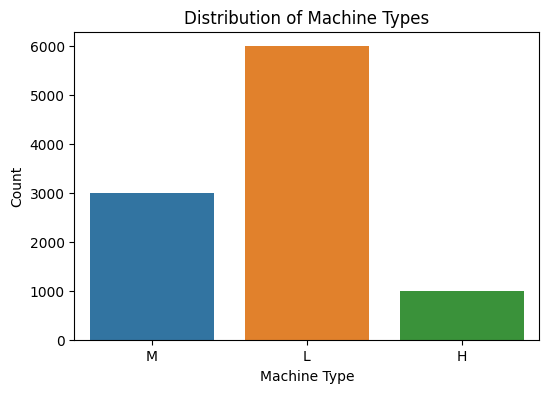

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.countplot(x='Type', data=df)
plt.title('Distribution of Machine Types')
plt.xlabel('Machine Type')
plt.ylabel('Count')
plt.show()

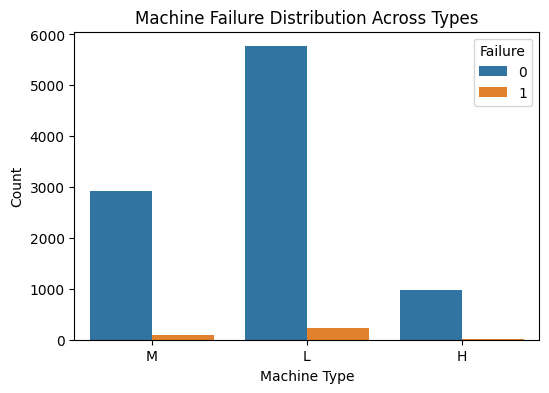

In [20]:
plt.figure(figsize=(6,4))
sns.countplot(x='Type', hue='Machine failure', data=df)
plt.title('Machine Failure Distribution Across Types')
plt.xlabel('Machine Type')
plt.ylabel('Count')
plt.legend(title='Failure')
plt.show()

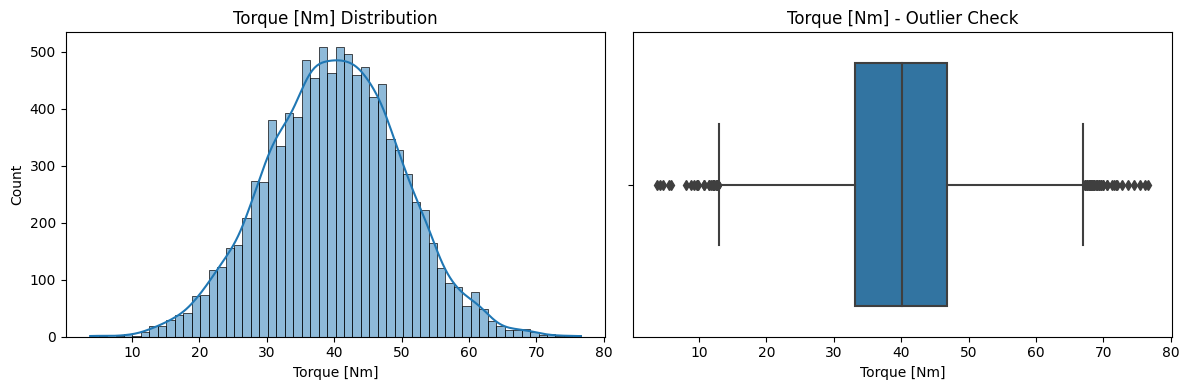

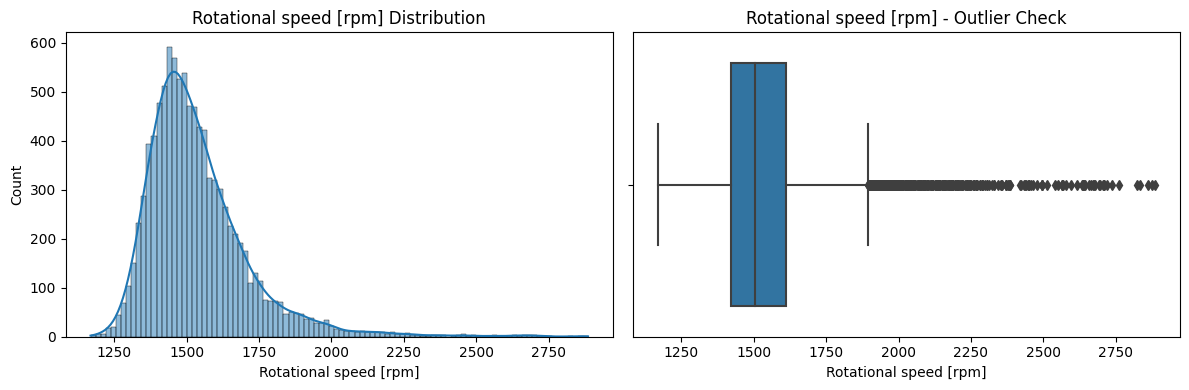

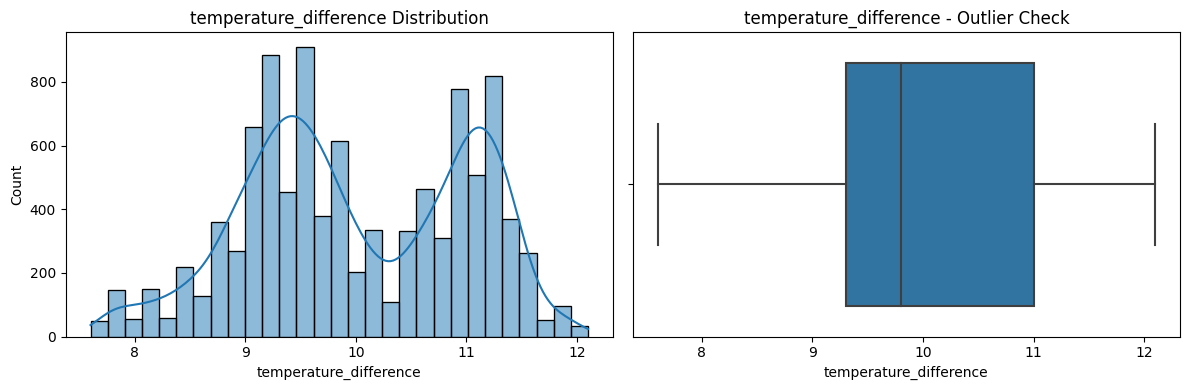

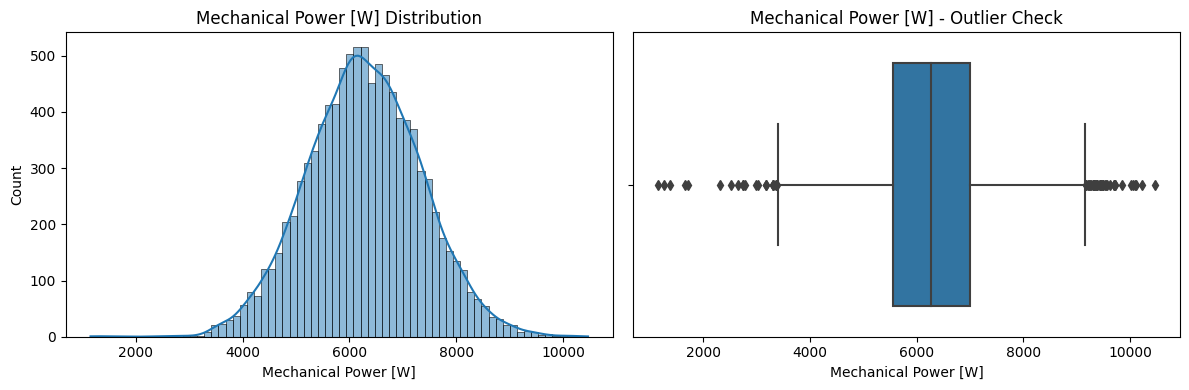

In [21]:
cols = ['Torque [Nm]', 'Rotational speed [rpm]', 'temperature_difference', 'Mechanical Power [W]']

for col in cols:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))  # 1 row, 2 columns

    # Histogram with KDE
    sns.histplot(data=df, x=col, kde=True, ax=axes[0])
    axes[0].set_title(f"{col} Distribution")

    # Boxplot
    sns.boxplot(data=df, x=col, ax=axes[1])
    axes[1].set_title(f"{col} - Outlier Check")

    plt.tight_layout()
    plt.show()

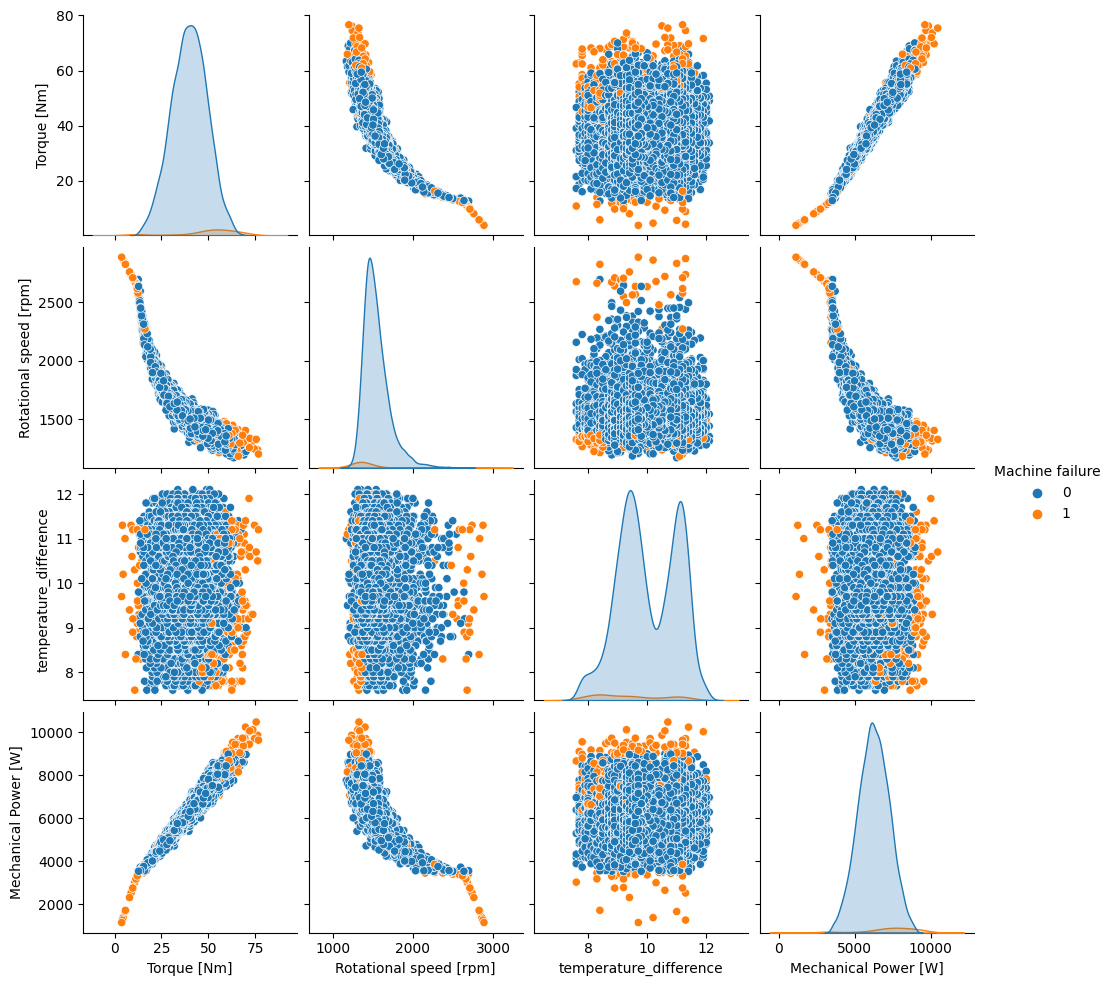

In [25]:
sns.pairplot(df[['Torque [Nm]', 'Rotational speed [rpm]', 'temperature_difference','Mechanical Power [W]', 'Machine failure']], hue='Machine failure')
plt.show()

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

<Axes: >

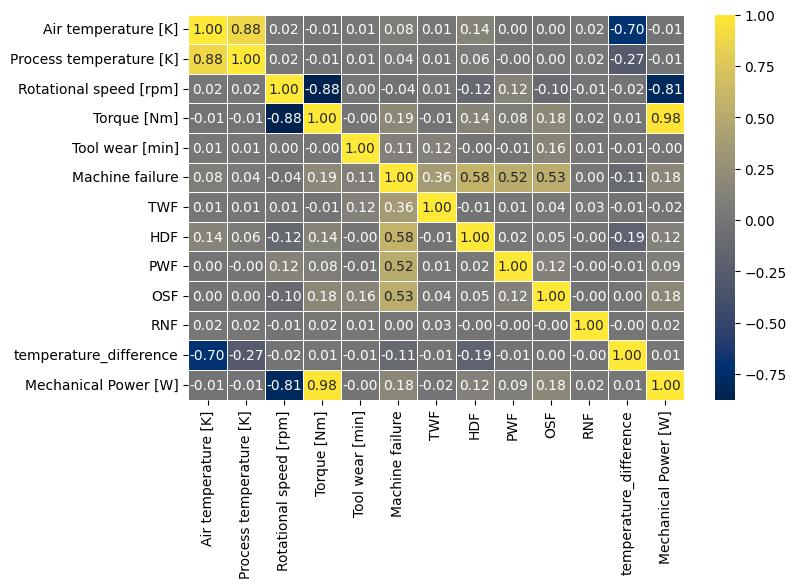

In [27]:
# Checking correlation between numerical features using a heatmap
corr_matrix=df.corr(numeric_only=True)
plt.figure(figsize=(8,5))
sns.heatmap(corr_matrix,annot=True,cmap='cividis',fmt=".2f", linewidths=0.5)

<Axes: >

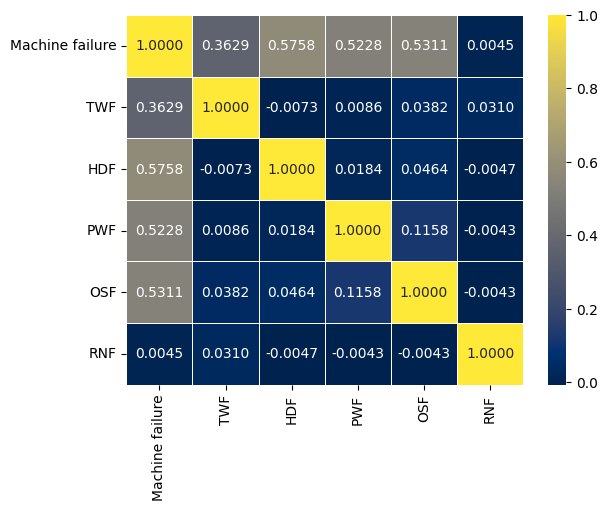

In [28]:
# Checking correlation between different failure using a heatmap
target=df.iloc[:,[6,7,8,9,10,11]]
target_mat=target.corr()
sns.heatmap(target_mat,annot=True,cmap="cividis",fmt=".4f",linewidth=0.5)

In [29]:
df.drop(columns=['TWF','HDF','PWF','OSF','RNF'],inplace=True)

In [30]:
df.sample(3)

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,temperature_difference,Mechanical Power [W]
9793,H,298.5,309.4,1414,46.7,102,0,10.9,6915.0434
6913,L,300.8,311.2,1481,38.5,181,0,10.4,5970.9634
9667,L,299.2,310.3,1352,48.9,238,1,11.1,6923.3162


In [31]:
# Label encoding categorical variables (column- Type)
from sklearn.preprocessing import LabelEncoder
df['Type'] = LabelEncoder().fit_transform(df['Type'])

In [32]:
# Scaling numerical features using StandardScaler for model compatibility
from sklearn.preprocessing import StandardScaler
scale=StandardScaler()
data=pd.DataFrame(scale.fit_transform(df),columns=df.columns,index=df.index)

In [33]:
data.sample(10)

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,temperature_difference,Mechanical Power [W]
2204,1.333889,-0.152453,-0.610355,-1.041841,0.613245,-0.093494,-0.187322,-0.600004,0.231546
167,-1.998335,-0.802401,-1.149563,-0.450571,0.292231,-1.460324,-0.187322,-0.100525,0.253229
9369,1.333889,-1.152374,-1.149563,0.045873,-0.319700,-0.533393,-0.187322,0.598745,-0.298015
7929,1.333889,0.297511,1.074667,0.726391,-1.082107,1.446152,-0.187322,0.998328,-1.102012
8209,-0.332223,-0.352437,0.535460,-0.824298,0.693498,-1.366059,-0.187322,1.497807,0.517116
610,-0.332223,-0.952389,-0.003747,-0.026641,-0.630682,-0.957582,-0.187322,1.897390,-0.811506
9376,-1.998335,-1.152374,-1.082162,1.111275,-1.232582,-0.187758,-0.187322,0.698641,-1.160113
3455,-1.998335,0.697480,0.198455,0.402866,0.151788,-1.523166,-0.187322,-1.099482,0.675918
9104,1.333889,-1.302362,-1.149563,0.062607,0.783783,-1.413191,-0.187322,0.898432,1.385601
7824,-0.332223,-0.052461,0.872464,-0.021063,-0.189288,0.817725,-0.187322,1.397911,-0.145561


In [34]:
Y=df.pop("Machine failure")
X=df

In [35]:
X

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],temperature_difference,Mechanical Power [W]
0,2,298.1,308.6,1551,42.8,0,10.5,6951.5906
1,1,298.2,308.7,1408,46.3,3,10.5,6826.7227
2,1,298.1,308.5,1498,49.4,5,10.4,7749.3875
3,1,298.2,308.6,1433,39.5,7,10.4,5927.5047
4,1,298.2,308.7,1408,40.0,9,10.5,5897.8166
...,...,...,...,...,...,...,...,...
9995,2,298.8,308.4,1604,29.5,14,9.6,4955.1294
9996,0,298.9,308.4,1632,31.8,17,9.5,5434.7040
9997,2,299.0,308.6,1645,33.4,22,9.6,5753.6175
9998,0,299.0,308.7,1408,48.5,25,9.7,7151.1026


In [36]:
Y

0       0
1       0
2       0
3       0
4       0
       ..
9995    0
9996    0
9997    0
9998    0
9999    0
Name: Machine failure, Length: 10000, dtype: int64

In [37]:
# SMOTE- Synthetic Minority Over-sampling Technique 
# SMOTE is a method for handling imbalanced datasets in machine learning. 
# Goal: To increase the number of instances in the minority class by creating synthetic samples. 
# How it works: SMOTE generates new examples by interpolating between existing minority class instances and their nearest neighbors.
# This helps the model learn better about the minority class and improves its performance on imbalanced datasets. 
# print distribution of class before SMOTE
from collections import Counter

counts = Counter(Y)
print(counts)

Counter({0: 9661, 1: 339})


In [47]:
!pip install imbalanced-learn==0.10.1  # Adjust version as needed

In [48]:
!pip show scikit-learn
!pip show imbalanced-learn

Name: scikit-learn
Version: 1.2.2
Summary: A set of python modules for machine learning and data mining
Home-page: http://scikit-learn.org
Author: 
Author-email: 
License: new BSD
Location: /usr/local/lib/python3.11/dist-packages
Requires: joblib, numpy, scipy, threadpoolctl
Required-by: bayesian-optimization, Boruta, category_encoders, cesium, eli5, fastai, hdbscan, hep_ml, imbalanced-learn, librosa, lime, mlxtend, nilearn, pyLDAvis, pynndescent, rgf-python, scikit-learn-intelex, scikit-optimize, scikit-plot, sentence-transformers, shap, sklearn-compat, sklearn-pandas, TPOT, tsfresh, umap-learn, woodwork, yellowbrick
Name: imbalanced-learn
Version: 0.10.1
Summary: Toolbox for imbalanced dataset in machine learning.
Home-page: https://github.com/scikit-learn-contrib/imbalanced-learn
Author: 
Author-email: 
License: MIT
Location: /usr/local/lib/python3.11/dist-packages
Requires: joblib, numpy, scikit-learn, scipy, threadpoolctl
Required-by: 


In [49]:
!pip install scikit-learn numpy scipy
!pip install -U imbalanced-learn

  Using cached scikit_learn-1.7.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (17 kB)
  Using cached scikit_learn-1.6.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (18 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.4/238.4 kB 5.4 MB/s eta 0:00:0000:01
Using cached scikit_learn-1.6.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.5 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.10.1
    Uninstalling imbalanced-learn-0.10.1:
      Successfully uninstalled imbalanced-learn-0.10.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
category-encoders 2.7.0 requires scikit-learn<1.

In [50]:
from imblearn.over_sampling import SMOTE

# Create and apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, Y)

# Verify the resampled data shape
print(f"Original shape: {X.shape}, {Y.shape}")
print(f"Resampled shape: {X_resampled.shape}, {y_resampled.shape}")

Original shape: (10000, 8), (10000,)
Resampled shape: (19322, 8), (19322,)


In [51]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, Y)

In [52]:
# print distribution of class AFTER SMOTE

from collections import Counter

counts = Counter(y_resampled )
print(counts)

Counter({0: 9661, 1: 9661})


In [53]:
#Performing train-test split

from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test=train_test_split(X_resampled,y_resampled,test_size=0.1)

In [54]:
# Importing machine learning models

from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV,SGDClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier,AdaBoostClassifier,BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

In [55]:
# Define models
models = {
    'Logistic Regression': LogisticRegression(),
        'Logistic Regression CV': LogisticRegressionCV(),
    'SGD': SGDClassifier(),
    
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'AdaBoost': AdaBoostClassifier(),
    'Bagging': BaggingClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'Support Vector Machine': SVC(),
    'K-Nearest Neighbors': KNeighborsClassifier()
}

In [56]:
# Creating a function to fit models on our dataset and check which model gives highest accuracy

def evaluate_model(X_train,X_test,Y_train,Y_test):
    result=[]
    for name, model in models.items():
        model.fit(X_train,Y_train)
        y_pred=model.predict(X_test)
        acc=accuracy_score(Y_test,y_pred)
        result.append((name,acc))
    # Sort models by accuracy
    result.sort(key=lambda x: x[1], reverse=True)
    return result

In [57]:
results = evaluate_model(X_train,X_test,Y_train,Y_test)
    
print("Model Performance:")
for name, acc in results:
    print(f"{name}: {acc:.6f}")

Model Performance:
Random Forest: 0.984480
Bagging: 0.976203
Decision Tree: 0.973099
Gradient Boosting: 0.958096
K-Nearest Neighbors: 0.938438
AdaBoost: 0.929643
Logistic Regression: 0.861355
Logistic Regression CV: 0.859803
Support Vector Machine: 0.795654
SGD: 0.723228


In [58]:
 RF=RandomForestClassifier(class_weight='balanced')

In [59]:
RF.fit(X_train,Y_train)
y_pred=RF.predict(X_test)
acc=accuracy_score(Y_test,y_pred)

In [60]:
acc

0.9813760993274703

In [61]:
# Lets check model performances using accuracy, precision, recall, and F1-score
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    ConfusionMatrixDisplay, 
    roc_auc_score, 
    RocCurveDisplay, 
    precision_recall_curve, 
    PrecisionRecallDisplay
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [62]:
def evaluate_model(model, X_test, y_test, model_name="Model"):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    # Classification Report
    print(f"--------- {model_name} Classification Report ------ \n\n")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title(f"{model_name} - Confusion Matrix")
    plt.show()

    # ROC Curve
    roc_auc = roc_auc_score(y_test, y_prob)
    RocCurveDisplay.from_predictions(y_test, y_prob)
    plt.title(f"{model_name} - ROC Curve (AUC = {roc_auc:.2f})")
    plt.show()

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    PrecisionRecallDisplay(precision=precision, recall=recall).plot()
    plt.title(f"{model_name} - Precision-Recall Curve")
    plt.show()

--------- Random Forest Classification Report ------ 


              precision    recall  f1-score   support

           0       0.98      0.98      0.98       956
           1       0.98      0.98      0.98       977

    accuracy                           0.98      1933
   macro avg       0.98      0.98      0.98      1933
weighted avg       0.98      0.98      0.98      1933



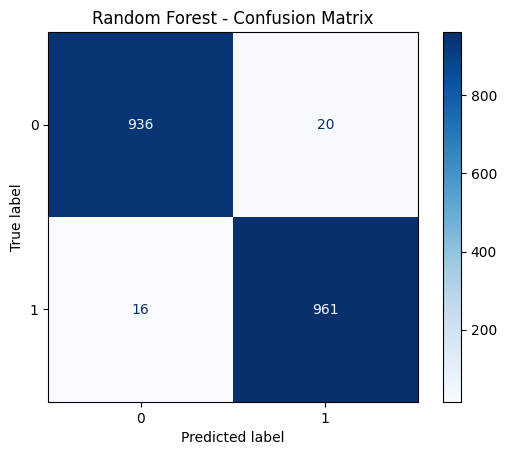

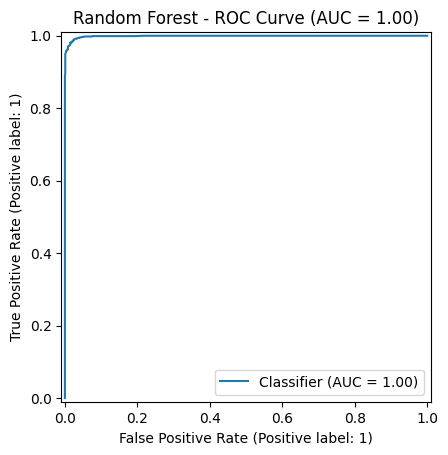

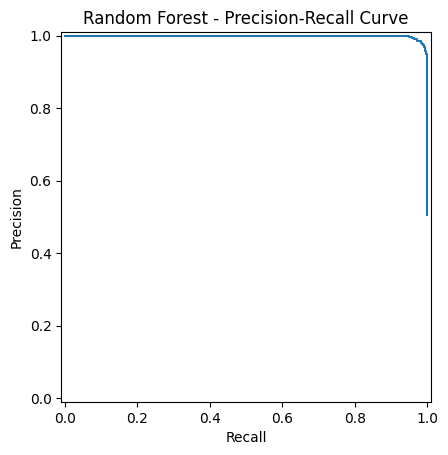

In [63]:
evaluate_model(RF, X_test, Y_test, model_name="Random Forest")

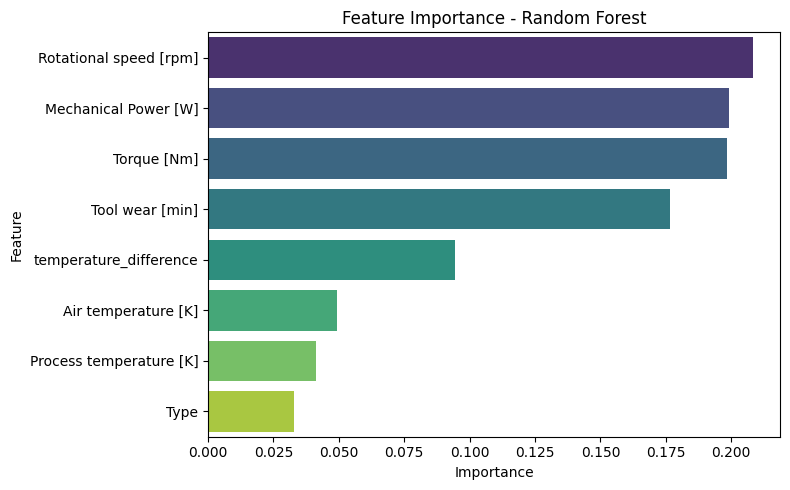

In [64]:
importances = RF.feature_importances_
feature_names = X.columns

# Create a DataFrame
feature_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(x='Importance', y='Feature', data=feature_imp_df, palette='viridis')
plt.title('Feature Importance - Random Forest')
plt.tight_layout()
plt.show()

# Analysis with Explainable AI

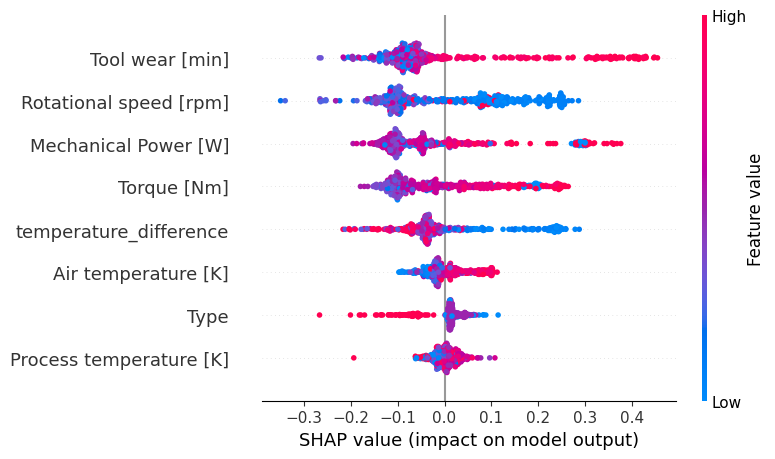

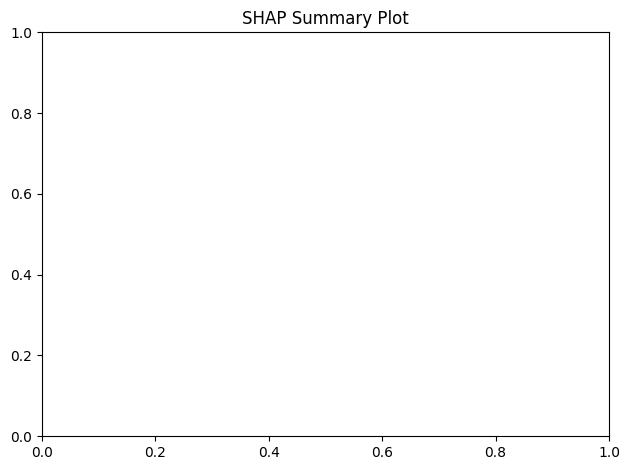

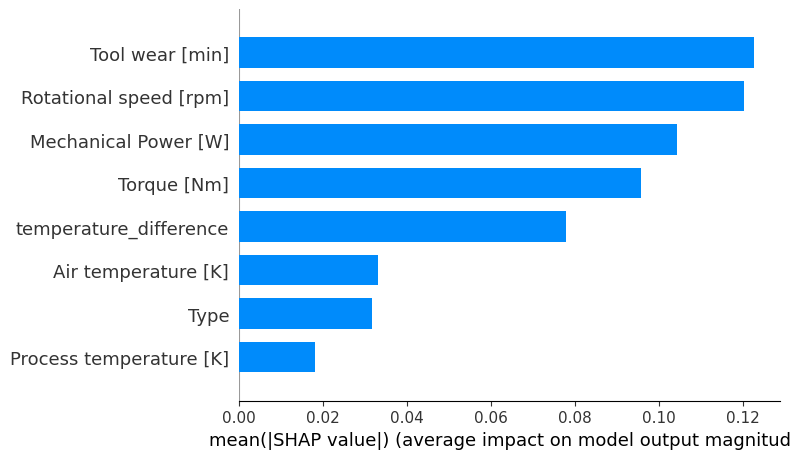

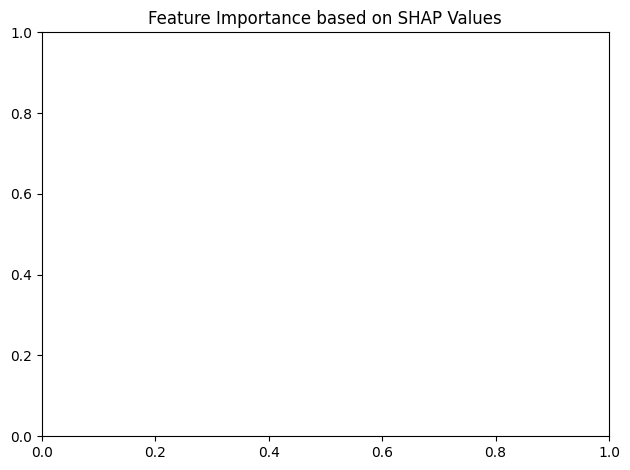

<Figure size 1000x500 with 0 Axes>

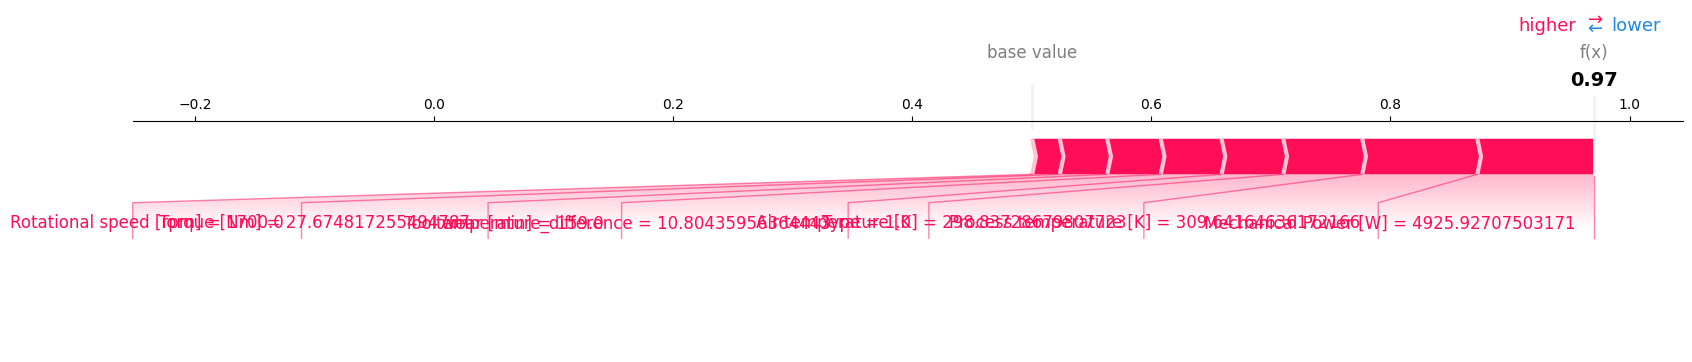

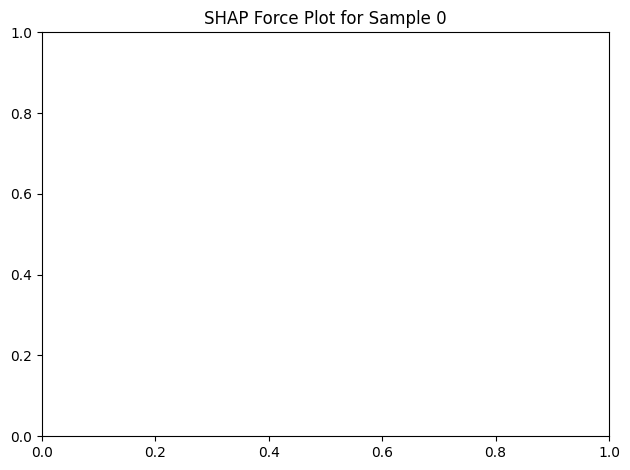

<Figure size 1000x600 with 0 Axes>

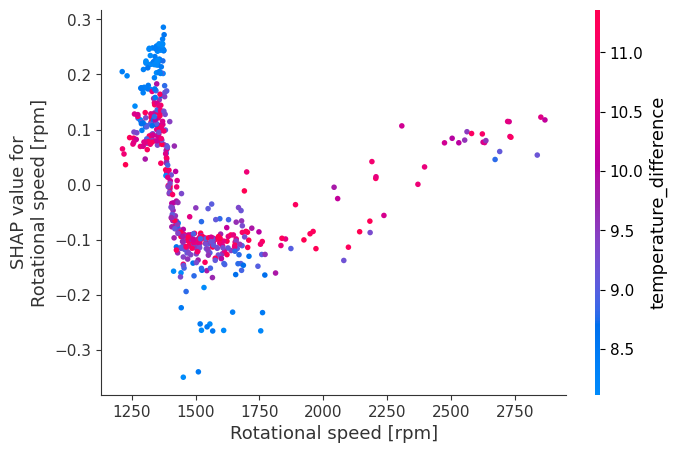

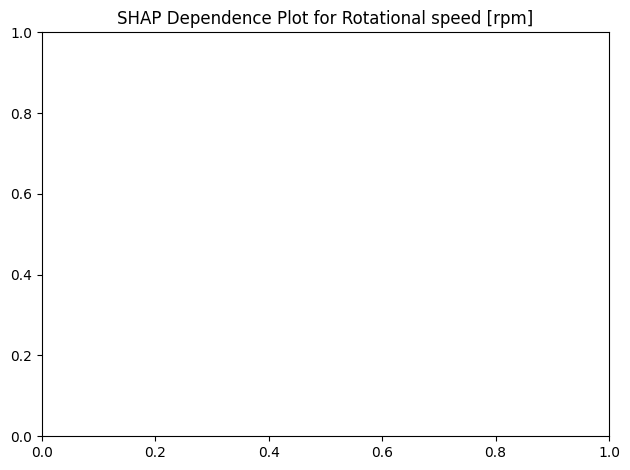

<Figure size 1000x600 with 0 Axes>

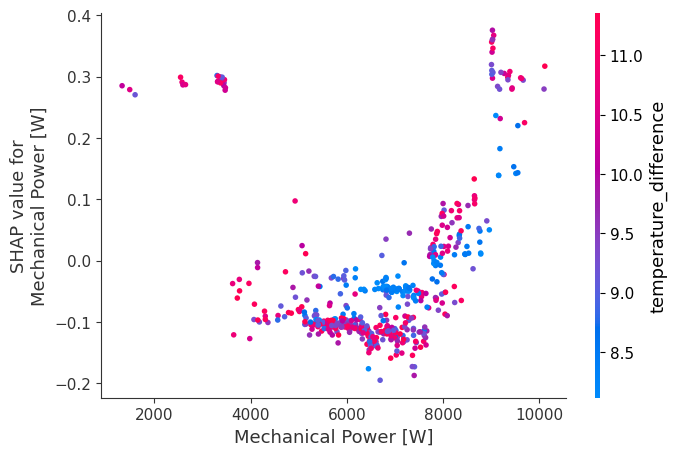

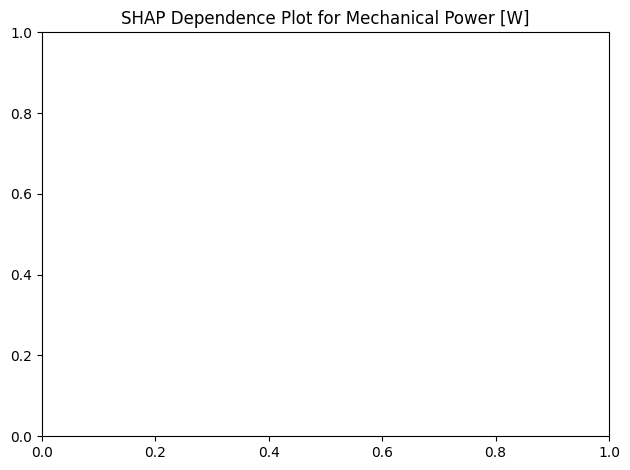

<Figure size 1000x600 with 0 Axes>

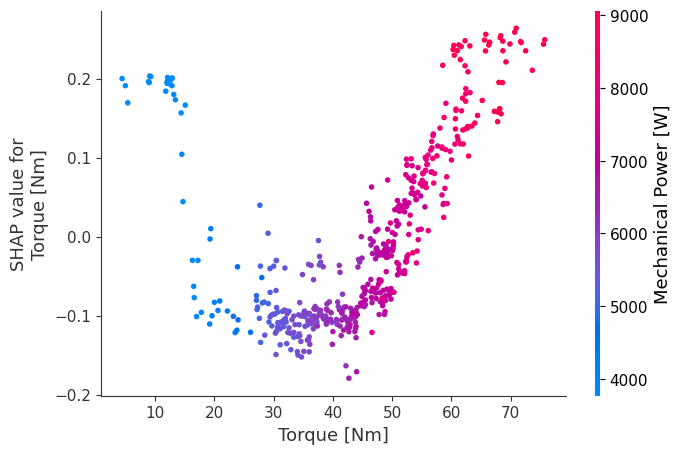

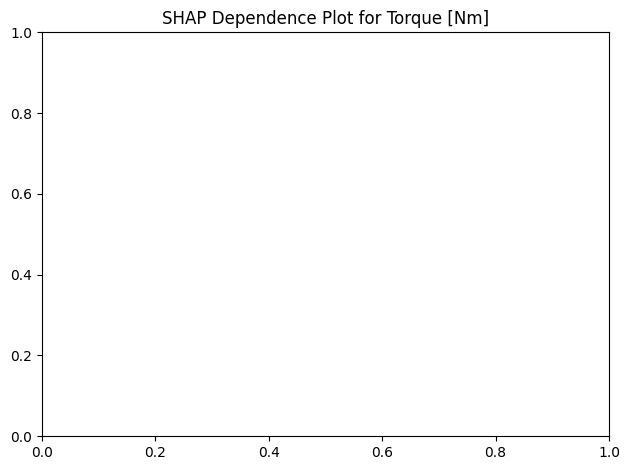

In [65]:
import shap
import matplotlib.pyplot as plt

# Create a SHAP explainer for your Random Forest model
explainer = shap.TreeExplainer(RF)

# Calculate SHAP values for the test set (using a sample for visualization)
sample_size = min(500, len(X_test))  # Limit sample size for better visualization
X_test_sample = X_test.iloc[:sample_size]
shap_values = explainer.shap_values(X_test_sample)

# Summary plot - shows overall feature importance and direction of effect
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values[1], X_test_sample, feature_names=X.columns)
plt.title("SHAP Summary Plot")
plt.tight_layout()
plt.show()

# Bar plot of mean absolute SHAP values
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values[1], X_test_sample, plot_type="bar", feature_names=X.columns)
plt.title("Feature Importance based on SHAP Values")
plt.tight_layout()
plt.show()

# Individual explanations for a single prediction
sample_idx = 0  # Index of a sample to explain
plt.figure(figsize=(10, 5))
shap.force_plot(explainer.expected_value[1], 
               shap_values[1][sample_idx], 
               X_test_sample.iloc[sample_idx],
               feature_names=X.columns,
               matplotlib=True)
plt.title(f"SHAP Force Plot for Sample {sample_idx}")
plt.tight_layout()
plt.show()

# Dependence plots for top features
top_features = feature_imp_df['Feature'].head(3).tolist()
for feature in top_features:
    plt.figure(figsize=(10, 6))
    shap.dependence_plot(feature, shap_values[1], X_test_sample, feature_names=X.columns)
    plt.title(f"SHAP Dependence Plot for {feature}")
    plt.tight_layout()
    plt.show()

<Figure size 1000x600 with 0 Axes>

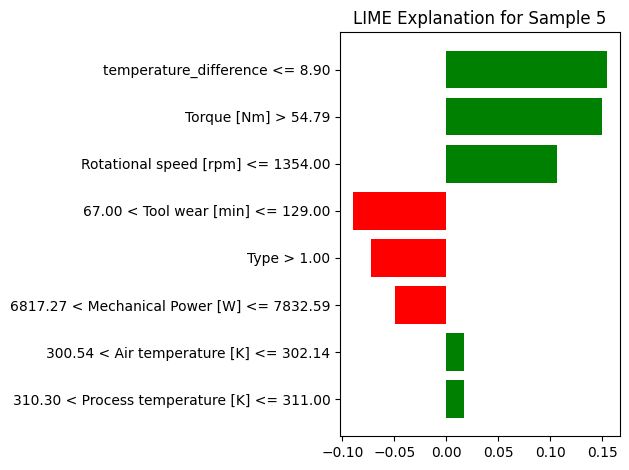

<Figure size 1000x500 with 0 Axes>

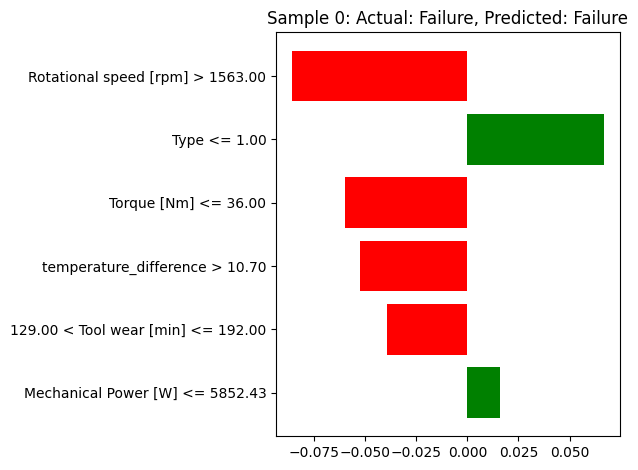

<Figure size 1000x500 with 0 Axes>

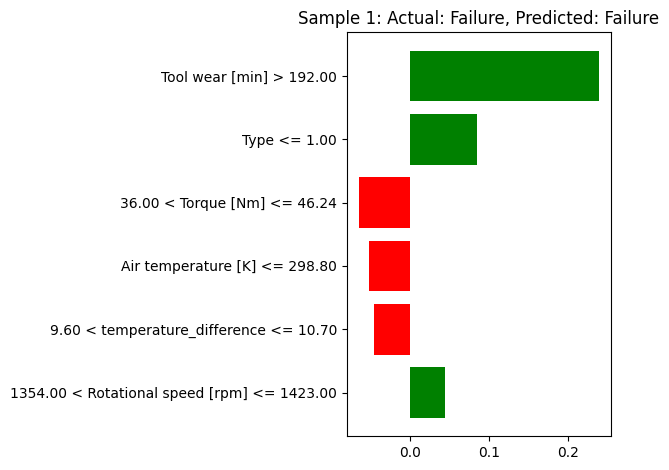

<Figure size 1000x500 with 0 Axes>

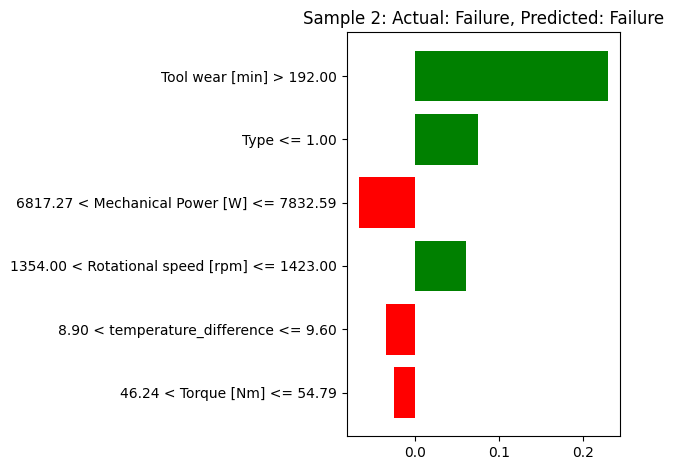

<Figure size 1000x500 with 0 Axes>

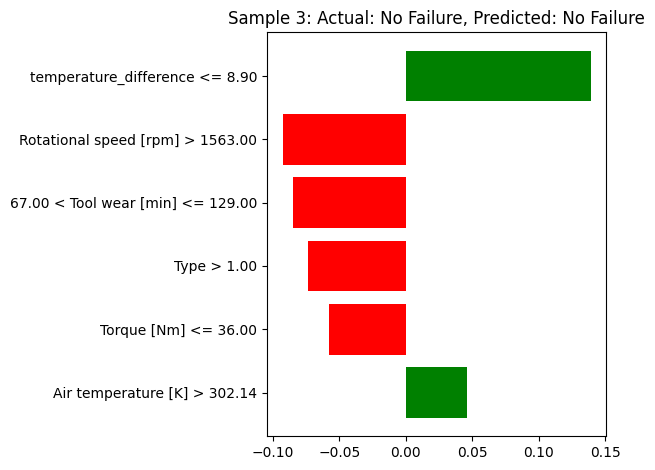

<Figure size 1000x500 with 0 Axes>

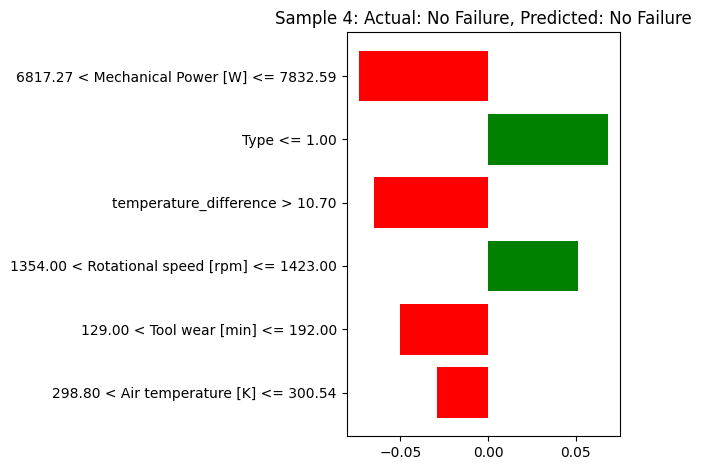

<Figure size 1000x500 with 0 Axes>

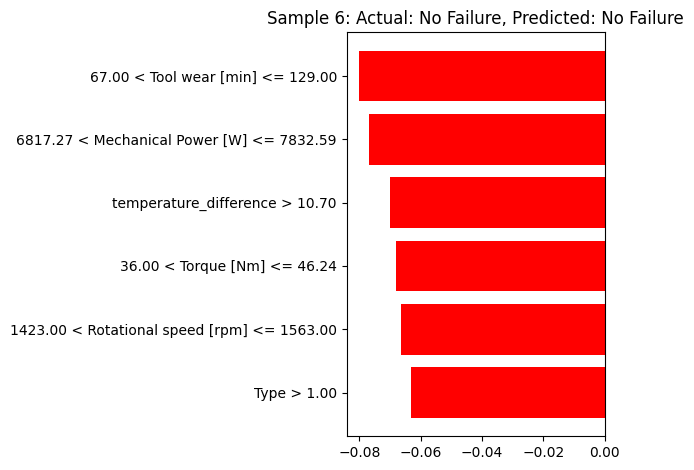

In [66]:
from lime import lime_tabular
import numpy as np

# Create a LIME explainer
lime_explainer = lime_tabular.LimeTabularExplainer(
    X_train.values,
    feature_names=X.columns,
    class_names=['No Failure', 'Failure'],
    mode='classification'
)

# Choose a sample to explain
sample_idx = 5  # Choose an interesting sample, preferably one with failure
sample = X_test.iloc[sample_idx]

# Generate explanation
explanation = lime_explainer.explain_instance(
    sample.values, 
    RF.predict_proba,
    num_features=10
)

# Visualize the explanation
plt.figure(figsize=(10, 6))
explanation.as_pyplot_figure()
plt.title(f"LIME Explanation for Sample {sample_idx}")
plt.tight_layout()
plt.show()

# Compare explanations for multiple samples (e.g., 3 failures and 3 non-failures)
failure_indices = np.where(Y_test == 1)[0][:3]
no_failure_indices = np.where(Y_test == 0)[0][:3]

for idx in np.concatenate([failure_indices, no_failure_indices]):
    explanation = lime_explainer.explain_instance(
        X_test.iloc[idx].values, 
        RF.predict_proba,
        num_features=6
    )
    plt.figure(figsize=(10, 5))
    explanation.as_pyplot_figure()
    actual = "Failure" if Y_test.iloc[idx] == 1 else "No Failure"
    pred = "Failure" if RF.predict([X_test.iloc[idx]])[0] == 1 else "No Failure"
    plt.title(f"Sample {idx}: Actual: {actual}, Predicted: {pred}")
    plt.tight_layout()
    plt.show()

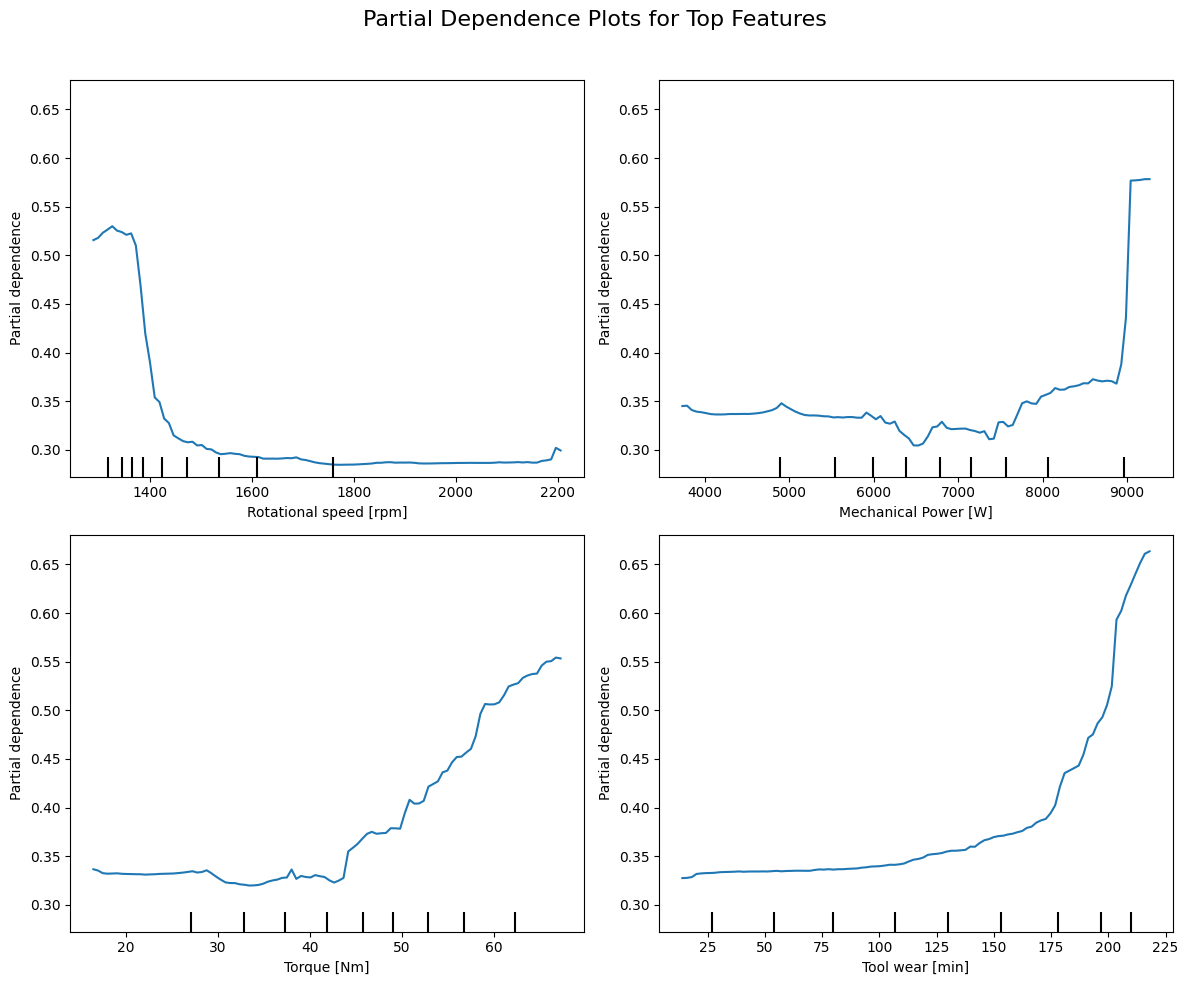

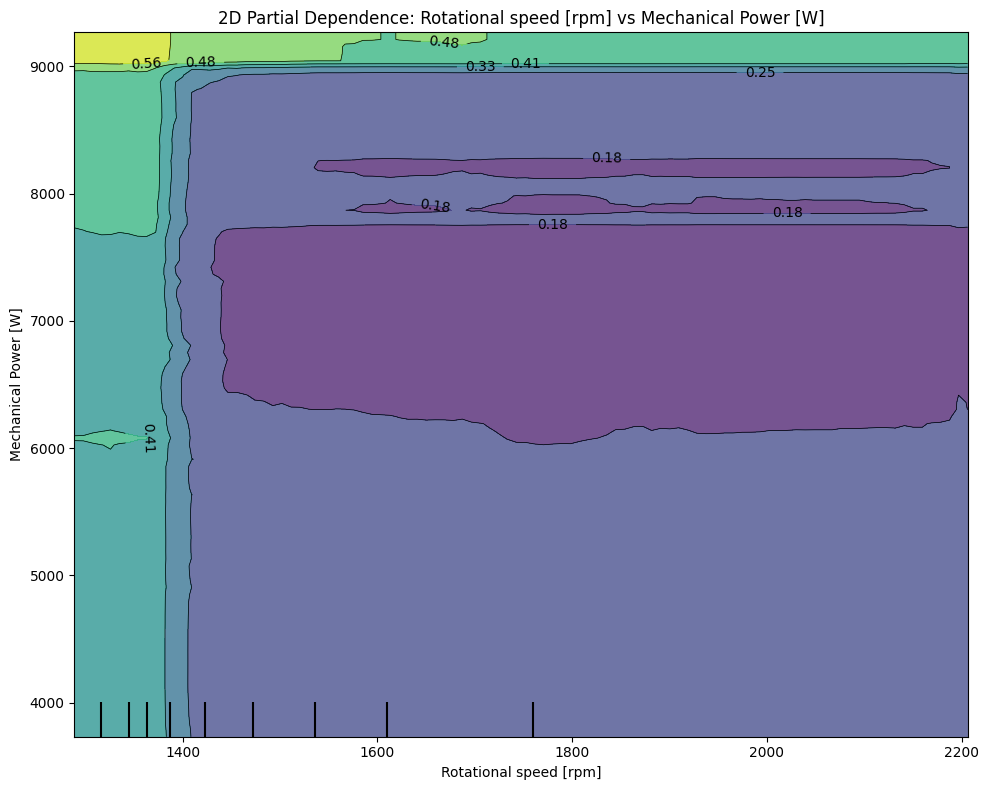

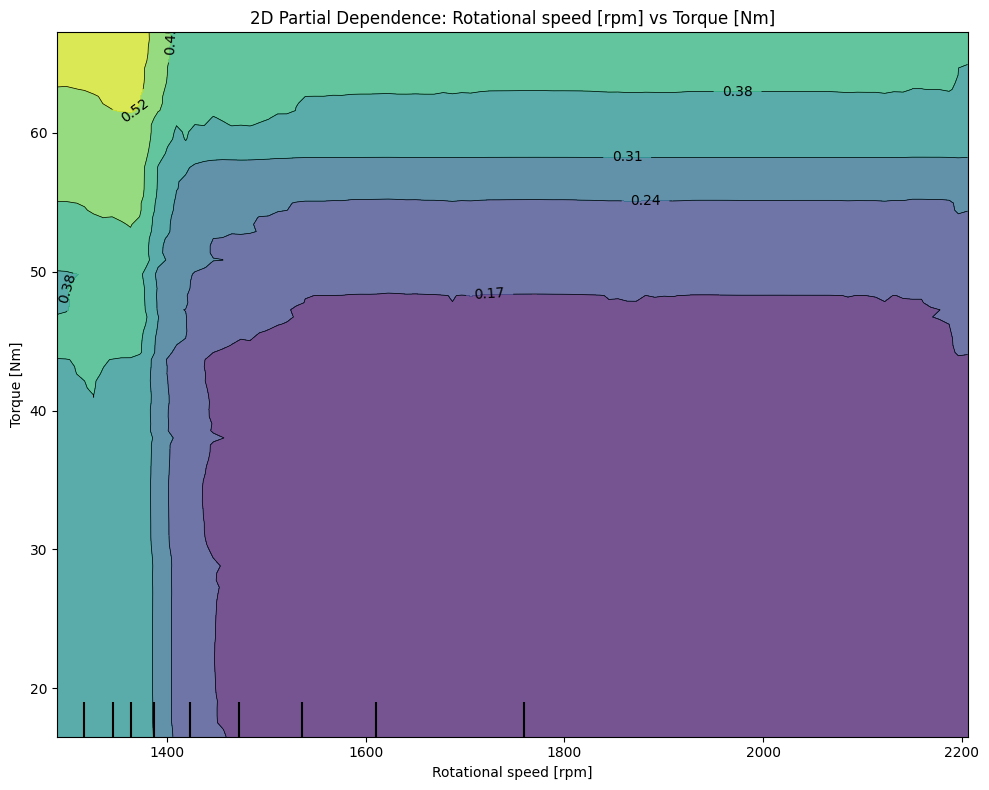

In [67]:
from sklearn.inspection import partial_dependence, PartialDependenceDisplay

# Select important features for PDP analysis based on your feature importance
top_features = feature_imp_df['Feature'].head(4).tolist()

# Individual PDPs
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
PartialDependenceDisplay.from_estimator(
    RF, 
    X_test, 
    features=top_features, 
    kind='average', 
    ax=ax.flatten()
)
fig.suptitle('Partial Dependence Plots for Top Features', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# 2D PDPs to show interactions (choose 2-3 feature pairs that might interact)
feature_pairs = [(top_features[0], top_features[1]), 
                 (top_features[0], top_features[2])]

for pair in feature_pairs:
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    PartialDependenceDisplay.from_estimator(
        RF, 
        X_test, 
        features=[pair], 
        kind='average',
        ax=ax
    )
    plt.title(f'2D Partial Dependence: {pair[0]} vs {pair[1]}')
    plt.tight_layout()
    plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.7.0 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.7.0 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.7.0 when using version 1.6.1. This might l

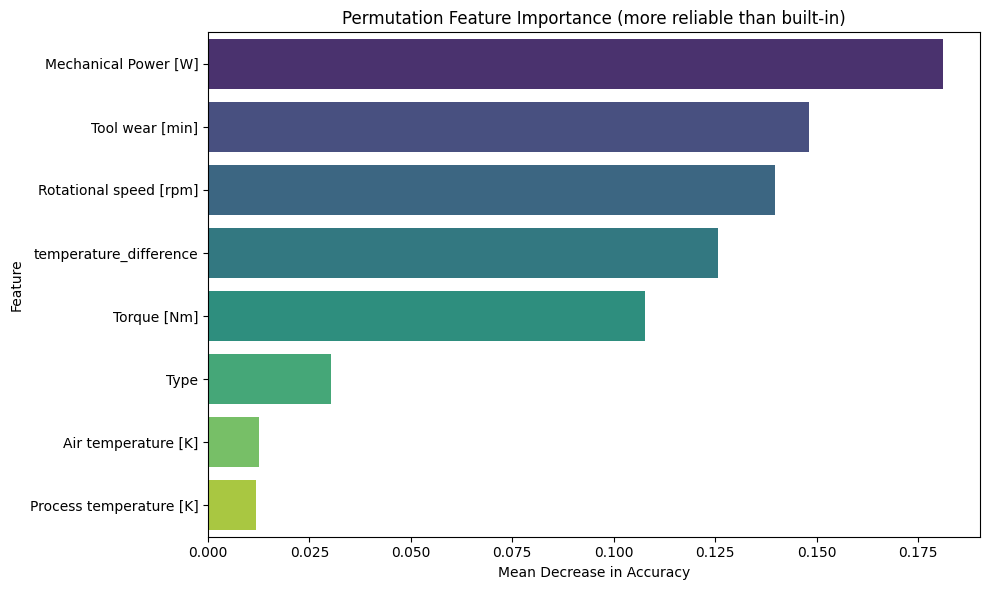

<Figure size 1200x600 with 0 Axes>

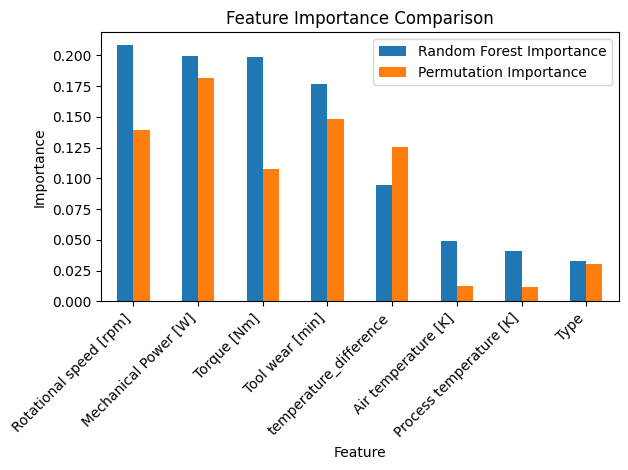

In [68]:
from sklearn.inspection import permutation_importance

# Compute permutation feature importance
result = permutation_importance(RF, X_test, Y_test, n_repeats=10, random_state=42, n_jobs=-1)
sorted_idx = result.importances_mean.argsort()

# Create a DataFrame for the results
perm_importance_df = pd.DataFrame({
    'Feature': X.columns[sorted_idx],
    'Importance': result.importances_mean[sorted_idx],
    'Std': result.importances_std[sorted_idx]
}).sort_values('Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=perm_importance_df, palette='viridis')
plt.title('Permutation Feature Importance (more reliable than built-in)')
plt.xlabel('Mean Decrease in Accuracy')
plt.tight_layout()
plt.show()

# Compare with original feature importance
comparison = pd.DataFrame({
    'Feature': feature_imp_df['Feature'],
    'Random Forest Importance': feature_imp_df['Importance'],
    'Permutation Importance': [perm_importance_df[perm_importance_df['Feature']==feat]['Importance'].values[0] 
                              if feat in perm_importance_df['Feature'].values else 0 
                              for feat in feature_imp_df['Feature']]
})

plt.figure(figsize=(12, 6))
comparison.set_index('Feature')[['Random Forest Importance', 'Permutation Importance']].plot(kind='bar')
plt.title('Feature Importance Comparison')
plt.ylabel('Importance')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

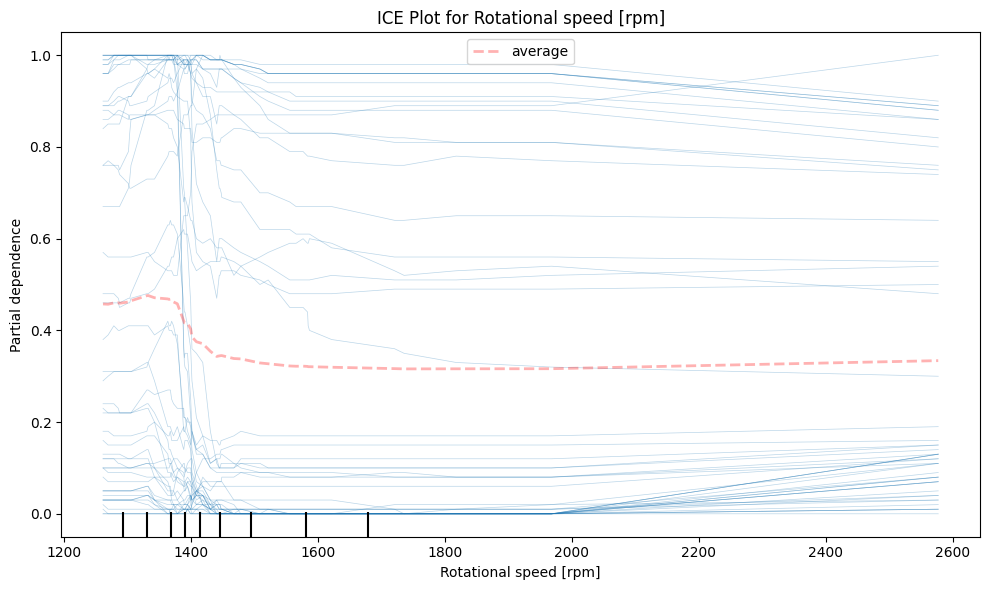

In [69]:
from sklearn.inspection import PartialDependenceDisplay

# Define the number of samples to use for ICE plots (use fewer samples for clarity)
n_samples = 50
sample_indices = np.random.choice(range(len(X_test)), n_samples, replace=False)

# Plot ICE curves for the top feature
top_feature = feature_imp_df['Feature'].iloc[0]  # Most important feature

fig, ax = plt.subplots(figsize=(10, 6))
PartialDependenceDisplay.from_estimator(
    RF, 
    X_test.iloc[sample_indices], 
    features=[top_feature], 
    kind='both',  # Shows both individual ICE lines and the average PD
    ax=ax,
    line_kw={"alpha": 0.3, "linewidth": 0.5},  # Make individual lines more transparent
    pd_line_kw={"color": "red", "linewidth": 2}  # Make average PD line stand out
)
plt.title(f'ICE Plot for {top_feature}')
plt.tight_layout()
plt.show()

In [70]:
from sklearn.tree import export_graphviz
import graphviz

# Extract a single tree from the forest (choose a tree with good performance)
tree_index = 0  # Change this to visualize different trees
tree = RF.estimators_[tree_index]

# Export the tree to a DOT file
dot_data = export_graphviz(
    tree,
    out_file=None,
    feature_names=X.columns,
    class_names=['No Failure', 'Failure'],
    filled=True,
    rounded=True,
    special_characters=True,
    max_depth=4  # Limit depth for better visualization
)

# Create and display graph
graph = graphviz.Source(dot_data)
graph.render("decision_tree_visualization", format="png", cleanup=True)

# Display important decision paths
print("Key decision paths for predicting machine failure:")
paths = tree.decision_path(X_test).toarray()
sample_indices = np.where(Y_test == 1)[0][:3]  # Get a few failure samples
for idx in sample_indices:
    path_indices = np.where(paths[idx] == 1)[0]
    path = []
    for node_idx in path_indices:
        if node_idx == 0:  # Skip the root
            continue
        if tree.tree_.children_left[node_idx] == -1:  # Leaf node
            leaf_value = tree.tree_.value[node_idx][0]
            prob_failure = leaf_value[1] / leaf_value.sum()
            path.append(f"Leaf: probability of failure = {prob_failure:.3f}")
        else:
            feature = X.columns[tree.tree_.feature[node_idx]]
            threshold = tree.tree_.threshold[node_idx]
            path.append(f"{feature} <= {threshold:.3f}")
    print(f"Sample {idx} decision path: {' -> '.join(path)}")

Key decision paths for predicting machine failure:
Sample 0 decision path: Mechanical Power [W] <= 7781.228 -> temperature_difference <= 8.600 -> Torque [Nm] <= 15.502 -> Tool wear [min] <= 168.500 -> Air temperature [K] <= 301.032 -> Mechanical Power [W] <= 5088.120 -> Torque [Nm] <= 28.218 -> Mechanical Power [W] <= 3805.912 -> Rotational speed [rpm] <= 1710.500 -> Tool wear [min] <= 154.500 -> Process temperature [K] <= 309.250 -> Leaf: probability of failure = 1.000
Sample 1 decision path: Rotational speed [rpm] <= 1410.500 -> temperature_difference <= 11.192 -> Mechanical Power [W] <= 7700.420 -> Tool wear [min] <= 205.500 -> Process temperature [K] <= 311.687 -> Type <= 1.500 -> Process temperature [K] <= 309.609 -> Air temperature [K] <= 299.692 -> Torque [Nm] <= 35.406 -> temperature_difference <= 10.967 -> Torque [Nm] <= 42.543 -> Mechanical Power [W] <= 6323.725 -> Type <= 0.500 -> Air temperature [K] <= 299.270 -> Tool wear [min] <= 210.500 -> Process temperature [K] <= 308.